In [32]:
import scanpy as sc
import numpy as np
import pandas as pd
import os
from scipy import sparse

import sys
sys.path.append("../../")

import importlib

import VITAE
import gdown

import random
import tensorflow as tf

## Preprocess Di Bella dataset

In [2]:
#has been normalize_total and log transform 
dd=sc.read("C:\\Users\\10270\\Desktop\\硕一上\\Wang\\Data\\transform.h5ad")

In [3]:
np.sum(np.exp(dd.X[0].todense())-1)

10000.0

In [4]:
data_loc="C:\\Users\\10270\\Desktop\\硕一上\\Wang\\Data\\"
metadata = pd.read_csv(data_loc + 'metaData_scDevSC.txt', delimiter='\t', index_col = 0)

dd.obs['Day'] = metadata['orig_ident'][1:metadata.shape[0]]
dd.obs['Clusters'] = metadata['New_cellType'][1:metadata.shape[0]]
dd.obs['Clusters'] = pd.Categorical(dd.obs['Clusters'], categories = [
    'Apical progenitors', 'Intermediate progenitors', 'Migrating neurons',
    'Immature neurons', 'Cajal Retzius cells', 'CThPN', 'SCPN',
    'NP', 'Layer 6b', 'Layer 4', 'DL CPN', 'DL_CPN_1', 'DL_CPN_2', 'UL CPN',
    'Interneurons', 'Astrocytes', 'Oligodendrocytes', 'Microglia',
    'Cycling glial cells', 'Ependymocytes', 'Endothelial cells',
    'VLMC', 'Pericytes','Red blood cells', 'Doublet', 'Low quality cells'
    ], ordered = True)


dd.obs['S_Score'] = pd.to_numeric(metadata['S_Score'][1:metadata.shape[0]])
dd.obs['G2M_Score'] = pd.to_numeric(metadata['G2M_Score'][1:metadata.shape[0]])

dd = dd[dd.obs['Clusters'].isin(['Doublet', 'Low quality cells']) == False]

D:\Anaconda_new\envs\bio_traj10\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (2,3,4,5,6,7,9,10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
dd.obs.index=dd.obs.index.tolist()
dd.obs['Day']=dd.obs['Day'].tolist()
dd.obs['Clusters']=dd.obs['Clusters'].tolist()
dd.obs['S_Score']=dd.obs['S_Score'].tolist()
dd.obs['G2M_Score']=dd.obs['G2M_Score'].tolist()

Trying to set attribute `.obs` of view, copying.


In [6]:
sc.pp.highly_variable_genes(dd, flavor = "seurat")
sc.pp.scale(dd, max_value=10)

In [7]:
day18 = np.array([np.nan] * dd.shape[0]).astype(object)
day18[(dd.obs["Day"] == "E18").values] = "E18"
day18[(dd.obs["Day"] == "E18_S1").values] = "E18_S1"
day18[(dd.obs["Day"] == "E18_S3").values] = "E18_S3"
dd.obs["merge_day_18"] = day18

In [8]:
dayP1 = np.array([np.nan] * dd.shape[0]).astype(object)
dayP1[dd.obs["Day"] == "P1"] = "P1"
dayP1[dd.obs["Day"] == "P1_S1"] = "P1_S1"
dd.obs["merge_P1"] = dayP1

In [9]:
dd.obs["merge_day_18"] = dd.obs["merge_day_18"].astype("category")
dd.obs["merge_P1"] = dd.obs["merge_P1"].astype("category")

In [10]:
dd.obs["Source"] = "Di Bella"

## Preprocess Mouse dataset

In [11]:
from VITAE.utils import load_data

mouse  = load_data(path = "D:/BioData/", file_name = "mouse_brain_merged")
sc.pp.normalize_total(mouse, target_sum=1e4)
sc.pp.log1p(mouse)
sc.pp.highly_variable_genes(mouse, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(mouse, max_value=10)

In [12]:
sc.tl.pca(mouse, n_comps = 64)
sc.pp.neighbors(mouse, n_neighbors = 20)
sc.tl.umap(mouse)

D:\Anaconda_new\envs\bio_traj10\lib\site-packages\numba\np\ufunc\parallel.py:366: NumbaWarning: The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11103. The TBB threading layer is disabled.
  warnings.warn(problem)


In [13]:
mouse_source = np.repeat("Yuzwa",mouse.shape[0])
mouse_source[mouse.obs["covariate_2"]==0] = "Ruan"
mouse.obs["Source"] = mouse_source

D:\Anaconda_new\envs\bio_traj10\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Source' as categorical


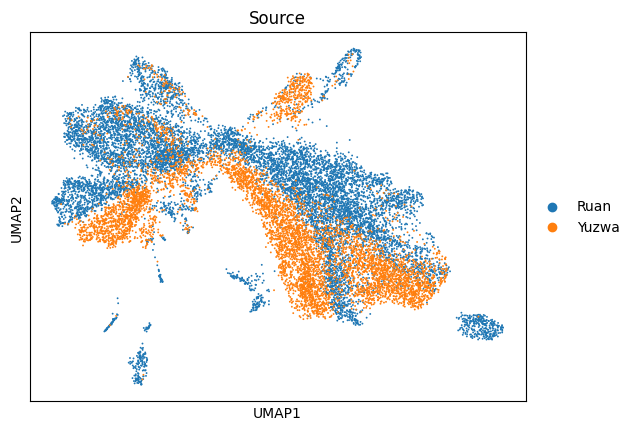

In [14]:
sc.pl.umap(mouse,color="Source")

In [15]:
mouse_day = mouse.obs.index.values.copy()
mouse_day = [x[:3] for x in mouse_day]
mouse.obs["Day"] = mouse_day

In [16]:
mouse.obs.rename(columns={"grouping": "Clusters", "covariate_0": "S_Score",
                     "covariate_1":"G2M_Score"},inplace = True)

## Merge two datasets

In [17]:
dd = dd.concatenate(mouse,join="inner")

## define highly_variable in merged dataset 
dd.var["highly_variable"] = dd.var["highly_variable-0"].astype(bool) | dd.var["highly_variable-1"].astype(bool)

In [18]:
group_dict = {"Immature Neuron" : "Immature neurons",
             "NEC":"Apical progenitors",
             "RGC":"Apical progenitors",
              "Layer I":"Cajal Retzius cells",
             "OPC":"Oligodendrocytes",
             "Interneurons":"Interneurons",
             "Endothelial Cell":"Endothelial cells",
             "Microglia":"Microglia",
             "Pericyte":"Pericytes",
             "Intermediate progenitors":"IPC"}

In [19]:
c = dd.obs["Clusters"].values.copy()
c = [x if group_dict.get(x) == None else group_dict.get(x) for x in c]
dd.obs["tidy_clusters"] = c.copy()

In [20]:
a = np.zeros(dd.shape[0])
a[dd.obs["Source"] == "Ruan"] = 1
dd.obs["cov1"] = a

a = np.zeros(dd.shape[0])
a[dd.obs["Source"] == "Yuzwa"] = 1
dd.obs["cov2"] = a

a = np.zeros(dd.shape[0])
a[dd.obs["Source"] == "Di Bella"] = 1
dd.obs["cov3"] = a

In [21]:
a = np.array([np.nan] * dd.shape[0])
#here is where I change
a[dd.obs["Day"] == "E18"] = 1
a[dd.obs["Day"] == "E18_S1"] = 2
a[dd.obs["Day"] == "E18_S3"] = 3
dd.obs["merge_18"] = a


a = np.array([np.nan] * dd.shape[0])
a[dd.obs["Day"] == "P1"] = 1
a[dd.obs["Day"] == "P1_S1"] = 2
dd.obs["merge_P1"] = a

dd.obs["merge_18"] = dd.obs["merge_18"].astype("category")
dd.obs["merge_P1"] = dd.obs["merge_P1"].astype("category")

In [22]:
a = np.array([np.nan] * dd.shape[0]).astype(object)
a[dd.obs["merge_P1"] == 1] = "P1"
a[dd.obs["merge_P1"] == 2] = "P1_S1"
dd.obs["merge_day_P1"] = a

In [23]:
a = dd.obs["tidy_clusters"].values.copy().astype(str)
a[(dd.obs["Day"].isin(["E14","E15","E16"])) & (a == "SCPN")] = "SCPN1"
dd.obs["Cluster2"] = a.copy()

## Naive Merge

In [24]:
sc.tl.pca(dd, n_comps = 64)
sc.pp.neighbors(dd, n_neighbors = 20)
sc.tl.umap(dd)

In [25]:
dd.obs["Source"] = dd.obs["Source"].astype(pd.CategoricalDtype(
                  ['Ruan', 'Yuzwa','Di Bella'], ordered=True))

### Fig S.4

D:\Anaconda_new\envs\bio_traj10\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Day' as categorical
D:\Anaconda_new\envs\bio_traj10\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Clusters' as categorical
D:\Anaconda_new\envs\bio_traj10\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories w

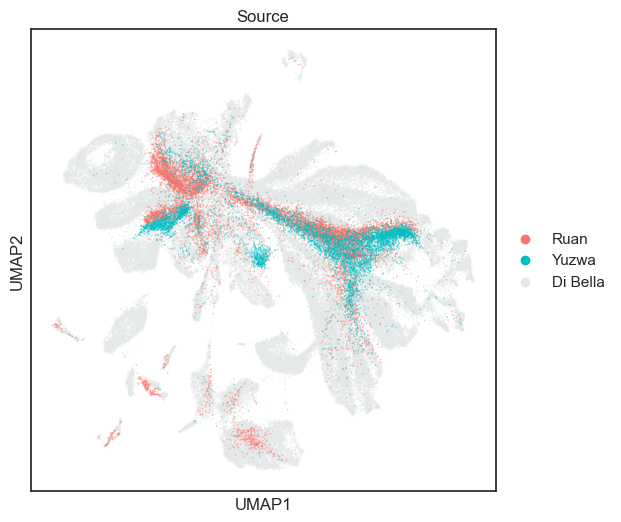

In [26]:
import seaborn
seaborn.set(rc={'figure.figsize':(6,6)},style = "white")
sc.pl.umap(dd,color="Source",size = 5,palette= ["#F8766D","#00BFC4","#E5E8E8"],alpha = 0.5,na_color="#E5E8E8")

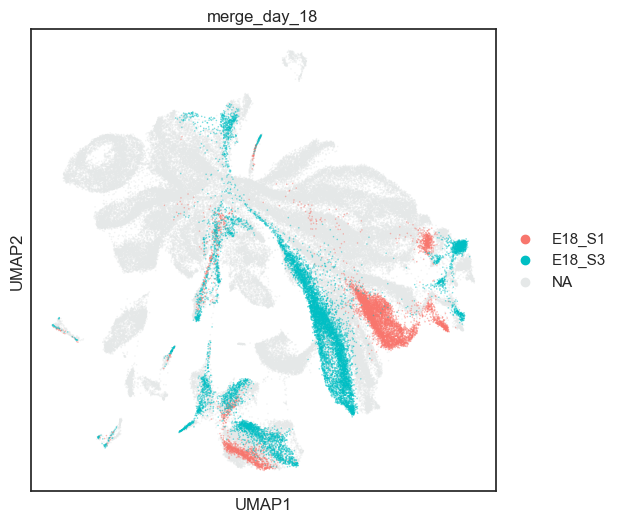

In [27]:
sc.pl.umap(dd,color="merge_day_18",size = 5,palette= ["#F8766D","#00BFC4","#E5E8E8"],alpha = 0.5,na_color="#E5E8E8")

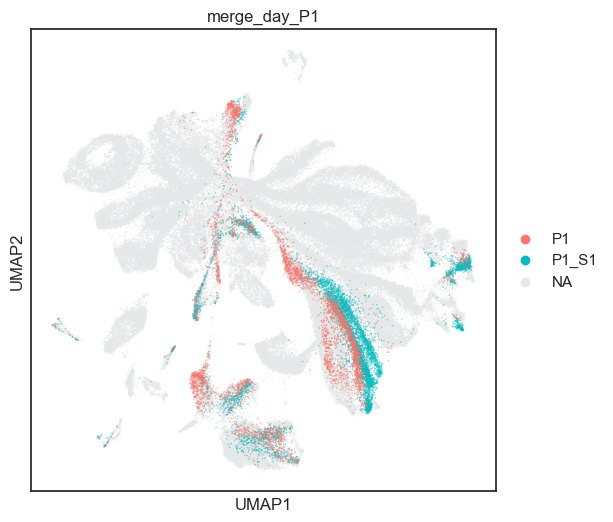

In [28]:
sc.pl.umap(dd,color="merge_day_P1",size = 5,palette= ["#F8766D","#00BFC4","#E5E8E8"],alpha = 0.5,na_color="#E5E8E8")

In [29]:
color_ggplot=["#F8766D","#E38900","#C49A00","#99A800","#53B400","#00BC56","#00C094","#00BFC4","#00B6EB","#06A4FF","#A58AFF","#DF70F8","#FB61D7","#FF66A8"]

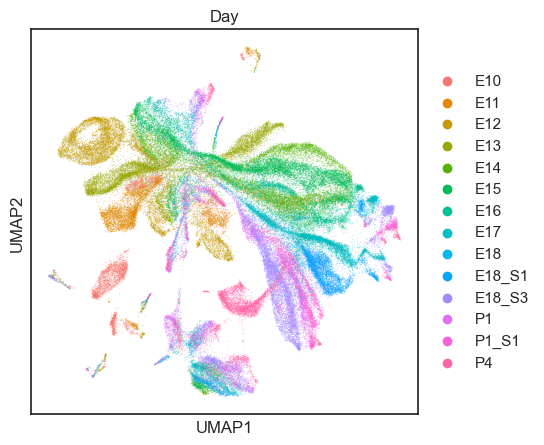

In [30]:
seaborn.set(rc={'figure.figsize':(5,5)},style = "white")
sc.pl.umap(dd,color="Day",size = 2, alpha=0.4,palette=color_ggplot)

## Train and load model

In [36]:
## download pre-trained weight
weight_url = "https://drive.google.com/file/d/1NI-QUyG8rA4QaMf32w_ME3r68KwtyK79/view?usp=drive_link"
output = 'weight/model.checkpoint.inference'
gdown.download(weight_url, output, quiet=False,fuzzy=True)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1NI-QUyG8rA4QaMf32w_ME3r68KwtyK79
From (redirected): https://drive.google.com/uc?id=1NI-QUyG8rA4QaMf32w_ME3r68KwtyK79&confirm=t&uuid=414fcb17-51f6-4a12-8c29-1b172da4c81b
To: C:\Users\10270\Desktop\硕一上\Wang\Trajectory\Dev\GitVersion\VITAE\paper\Application on integrating mouse brain datasets\weight\model.checkpoint.inference
100%|███████████████████████████████████████████████████████████████████████████████| 221M/221M [01:18<00:00, 2.82MB/s]


'weight/model.checkpoint.inference'

In [37]:
seed = 400
tf.keras.backend.clear_session()
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

dd.obs["pi"]=np.random.uniform(size=dd.shape[0])

model = VITAE.VITAE(adata = dd,
    #        adata_layer_counts = 'counts',
            hidden_layers = [48, 24],
            latent_space_dim = 16,
            pi_covariates = ['pi'],
            model_type = 'Gaussian',
            covariates = ['S_Score', 'G2M_Score',"cov1","cov2"],npc = 96)

In [38]:
model.load_model('weight/model.checkpoint',load_labels=True)

Initial clustering labels saved as 'vitae_init_clustering' in self.adata.obs.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocast

'vitae_new_clustering' updated based on the projected cell positions.
Cell projection uncertainties stored as 'projection_uncertainty' in self.adata.obs


../..\VITAE\VITAE.py:708: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.ax.figure.show()


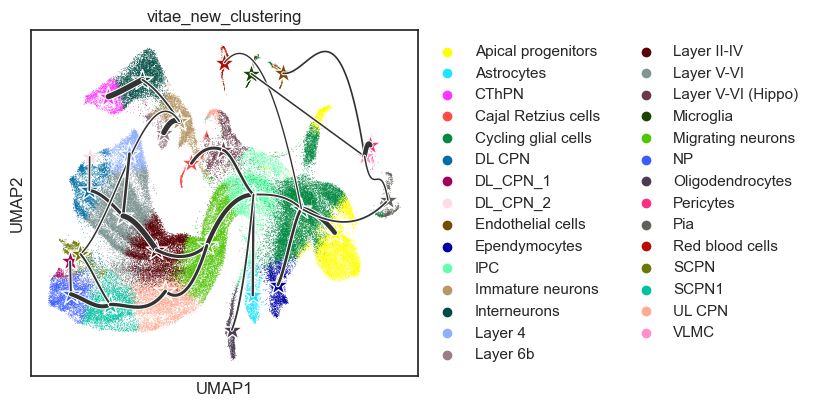

In [42]:
model.infer_backbone(cutoff = 0, no_loop = True, visualize = True,method = "modified_w_base");

'vitae_new_clustering' updated based on the projected cell positions.
Cell projection uncertainties stored as 'projection_uncertainty' in self.adata.obs


../..\VITAE\VITAE.py:708: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.ax.figure.show()


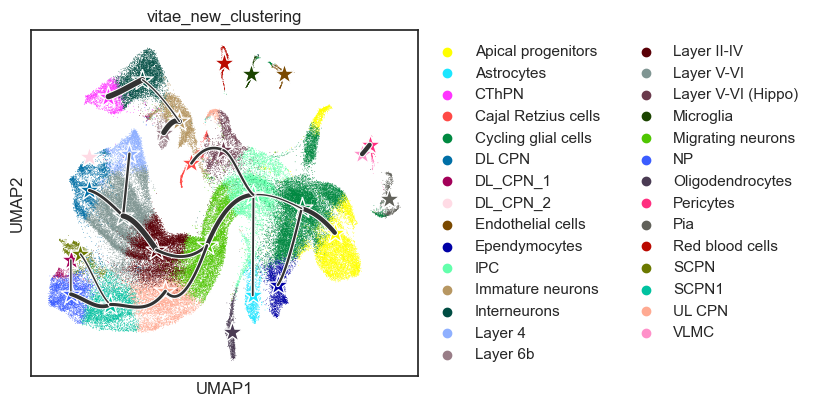

In [44]:
cf = list(model.backbone.edges(data = True))
cf = [x[2]["weight"] for x in cf]
cf = np.sort(cf)[-20] - 1e-10
model.infer_backbone(cutoff = cf, no_loop = True, visualize = True,method = "modified_w_base")

Cell projection uncertainties stored as 'pseudotime' in self.adata.obs


../..\VITAE\VITAE.py:996: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.ax.figure.show()


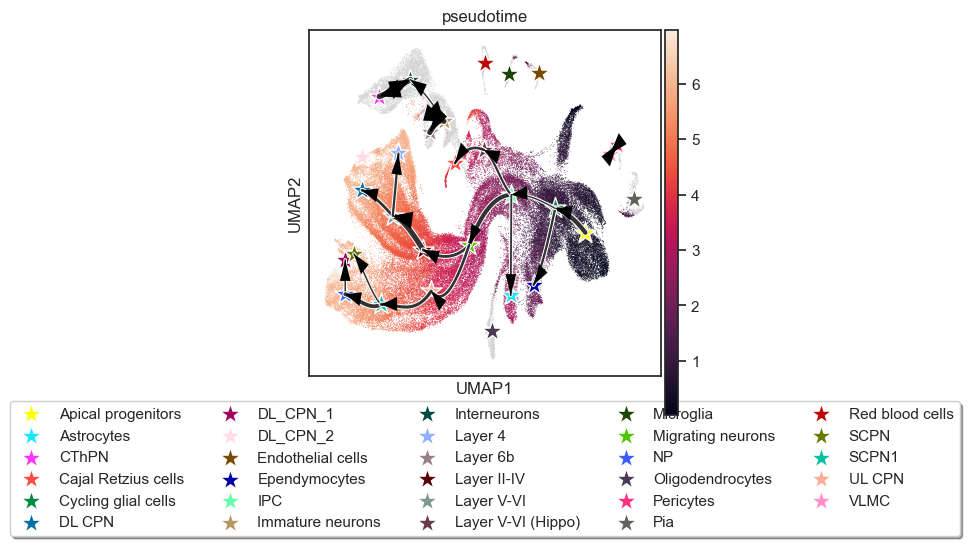

In [45]:
model.infer_trajectory("Apical progenitors",color = "pseudotime");

### Fig 4.c

Trying to set attribute `.obs` of view, copying.
D:\Anaconda_new\envs\bio_traj10\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
D:\Anaconda_new\envs\bio_traj10\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


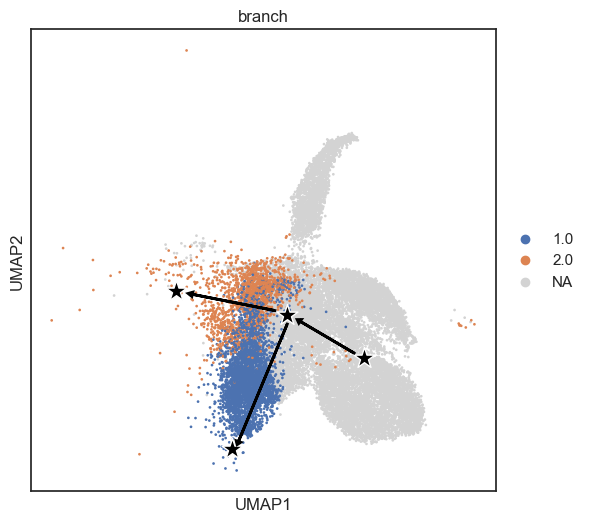

In [46]:
ap_full = model._adata[(model._adata.obs["pseudotime"]<=2) & (model._adata.obs["tidy_clusters"]=="Apical progenitors")]

w_proj = model.cell_position_projected[model._adata.obs.index.isin(ap_full.obs.index),:]
idx1 = model.labels_map[model.labels_map.label_names == "Cycling glial cells"].index[0]
idx2 = model.labels_map[model.labels_map.label_names == "Ependymocytes"].index[0]
idx3 = model.labels_map[model.labels_map.label_names == "IPC"].index[0]

b1 = np.where((w_proj[:,idx1] > 0) & (w_proj[:,idx2] > 0))[0]
b2 = np.where((w_proj[:,idx1] > 0) & (w_proj[:,idx3] > 0))[0]

ap_full.obs["branch"] = np.nan
ap_full.obs["branch"][b1] = 1
ap_full.obs["branch"][b2] = 2
ap_full.obs["branch"] = ap_full.obs["branch"].astype("category")

seaborn.set(rc={'figure.figsize':(6,6)},style = "white")

center0 = model._adata[model._adata.obs["vitae_new_clustering"]=="Apical progenitors"].obsm["X_umap"].mean(axis=0)
center1 = model._adata[model._adata.obs["vitae_new_clustering"]=="Cycling glial cells"].obsm["X_umap"].mean(axis=0)
center2 = model._adata[model._adata.obs["vitae_new_clustering"]=="Ependymocytes"].obsm["X_umap"].mean(axis=0)
center3 = model._adata[model._adata.obs["vitae_new_clustering"]=="IPC"].obsm["X_umap"].mean(axis=0)

ax = sc.pl.umap(ap_full,color="branch",show=False,size=15)
ax.scatter(x=center0[0],y=center0[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center1[0],y=center1[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center2[0],y=center2[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center3[0],y=center3[1],marker='*',s = 250,c="black",edgecolors="white")

ax.arrow(x=center0[0]-0.4,y=center0[1]+0.2,
         dx=center1[0]-center0[0]+0.8,
         dy=center1[1]-center0[1]-0.4,
        length_includes_head=True,
        head_width=0.2, head_length=0.15,
        #edgecolor = "white",
        #facecolor = "black",
         color = "black",
        linewidth = 2)

ax.arrow(x=center1[0],y=center1[1]-0.4,
         dx=center2[0]-center1[0]+0.2,
         dy=center2[1]-center1[1]+0.6,
        length_includes_head=True,
        head_width=0.2, head_length=0.15,
        #edgecolor = "white",
        #facecolor = "black",
         color = "black",
        linewidth = 2)

ax.arrow(x=center1[0]-0.5,y=center1[1]+0.2,
         dx=center3[0]-center1[0]+1,
         dy=center3[1]-center1[1]-0.3,
        length_includes_head=True,
        head_width=0.2, head_length=0.18,
        #edgecolor = "white",
        #facecolor = "black",
         color = "black",
        linewidth = 2)
#ax.figure.savefig("figures/ap_full.pdf",dpi = 400, bbox_inches='tight')

### Fig 4.e

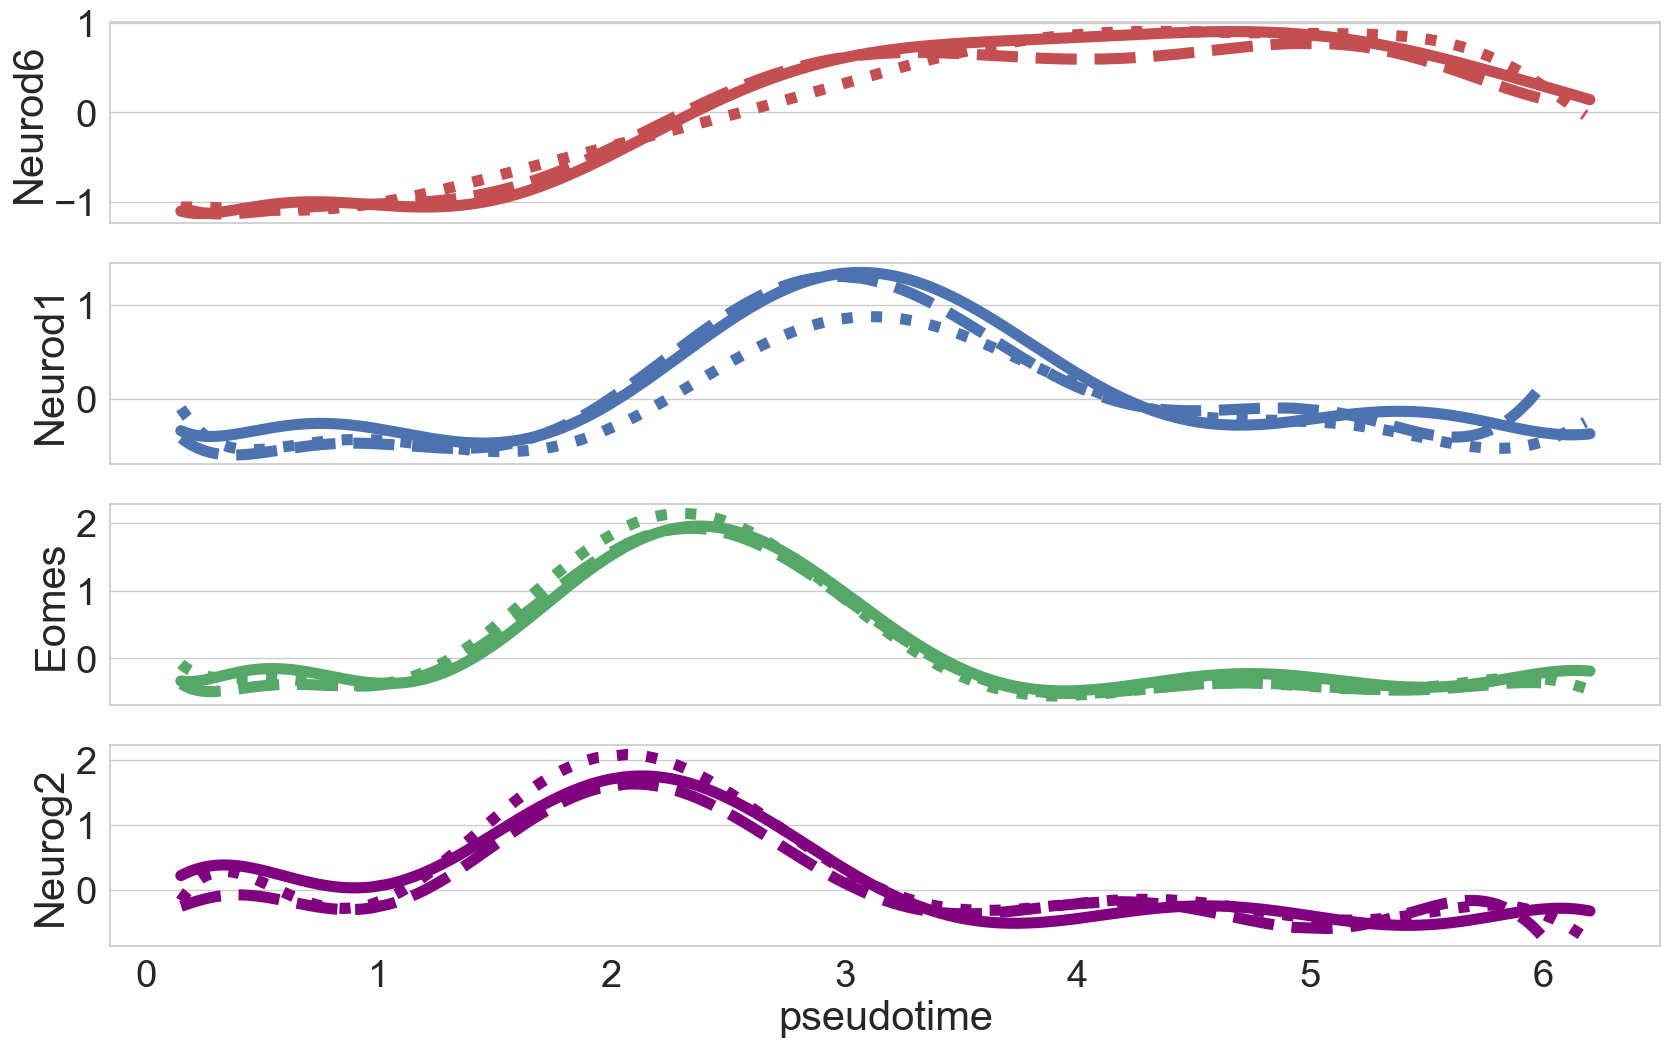

In [50]:
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.pyplot as plt

df_4d = sc.get.obs_df(dd,keys = ["Neurod6","Neurod1","Eomes","Neurog2"])
df_4d.columns = ["Neurod6","Neurod1","Eomes","Neurog2"]
df_4d[["Source","pseudotime"]] = model.adata.obs[["Source","pseudotime"]].values.copy()

line_style = ["dotted","dashed","solid"]
color = ["r","b","g","purple"]
gene_list = ["Neurod6","Neurod1","Eomes","Neurog2"]
line_idx = 0

sns.set(rc={'figure.figsize':(20,12)})
sns.set_theme(style="whitegrid",font_scale = 2.5)
fig, axs = plt.subplots(4)
Source_list = ["Yuzwa","Ruan","Di Bella"]

for j in range(4):
    gene = gene_list[j]
    for i in range(3):
        Source = Source_list[i]

        a = df_4d[df_4d["Source"]==Source].copy()
        a = a[~np.isnan(a["pseudotime"].values.astype(float))]
        #a = a[a[gene]!=np.min(a[gene])]
        a = a.sort_values("pseudotime")

        list_x = a["pseudotime"].values.astype(float)
        list_y = a[gene].values.astype(float)
        poly = np.polyfit(list_x,list_y,10)
        poly_y = np.poly1d(poly)(list_x)

        a["smooth"] = poly_y
        axs[j].yaxis.set_major_locator(ticker.MultipleLocator(1))
        axs[j].grid(axis='x')
        axs[j].set_ylabel(gene)
        if j != 3:
            axs[j].tick_params(labelbottom=False)

        if i % 3 == 2:
            #sns.lineplot(a[(a.pseudotime < 6.2) & (a.pseudotime > 0.15)],x = "pseudotime", y = "smooth",color=color[j],label = gene,ax=axs[j]).lines[i].set_linestyle(line_style[i])
            sns.lineplot(data = a[(a.pseudotime < 6.2) & (a.pseudotime > 0.15)],x = "pseudotime", y = "smooth",color=color[j],ax=axs[j],linewidth = 8).lines[i].set_linestyle(line_style[i])
        else:
            sns.lineplot(data = a[(a.pseudotime < 6.2) & (a.pseudotime > 0.15)],x = "pseudotime", y = "smooth",color=color[j],ax=axs[j],linewidth = 8).lines[i].set_linestyle(line_style[i])
        line_idx += 1
#fig.figure.savefig("figures/psd_4_genes.pdf",dpi = 400, bbox_inches='tight')

### Fig S.6

Trying to set attribute `._uns` of view, copying.


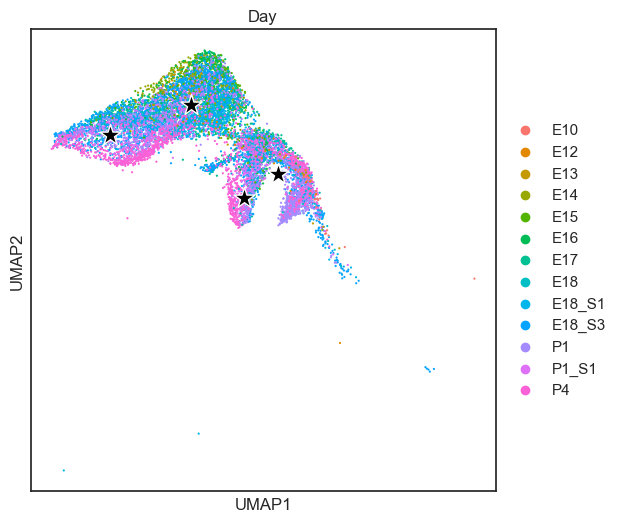

In [170]:
seaborn.set(rc={'figure.figsize':(6,6)},style = "white")
mask1 = model._adata.obs["Cluster2"] == "Interneurons"
mask2 = model._adata.obs["vitae_new_clustering"].isin(["CThPN","Layer 6b",'Interneurons', 'Immature neurons'])
inter = model._adata[mask1 & mask2]

ax = sc.pl.umap(inter,
           color=["Day"],palette=color_ggplot,size = 10,ncols=2,
                show = False)

center1 = inter[inter.obs["vitae_new_clustering"] == "CThPN"].obsm["X_umap"].mean(axis=0)
center2 = inter[inter.obs["vitae_new_clustering"] == "Layer 6b"].obsm["X_umap"].mean(axis=0)
center3 = inter[inter.obs["vitae_new_clustering"] == "Interneurons"].obsm["X_umap"].mean(axis=0)
center4 = inter[inter.obs["vitae_new_clustering"] == "Immature neurons"].obsm["X_umap"].mean(axis=0)

ax.scatter(x=center1[0],y=center1[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center2[0],y=center2[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center3[0],y=center3[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center4[0],y=center4[1],marker='*',s = 250,c="black",edgecolors="white")

#ax.figure.savefig("figures/Interneurons_Day.pdf",dpi = 700, bbox_inches='tight')

### Fig 5.f

Trying to set attribute `._uns` of view, copying.


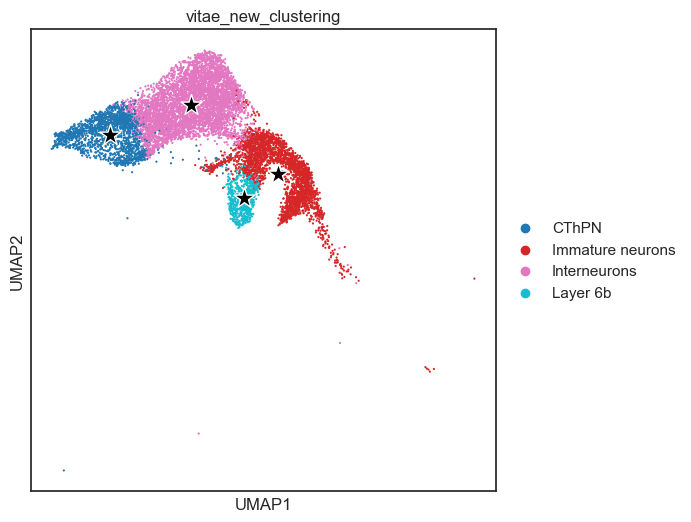

In [51]:
seaborn.set(rc={'figure.figsize':(6,6)},style = "white")
mask1 = model._adata.obs["Cluster2"] == "Interneurons"
mask2 = model._adata.obs["vitae_new_clustering"].isin(["CThPN","Layer 6b",'Interneurons', 'Immature neurons'])
inter = model._adata[mask1 & mask2]
ax = sc.pl.umap(inter,
           color=["vitae_new_clustering"],palette="tab10",size = 10,ncols=2,
                show = False)

center1 = inter[inter.obs["vitae_new_clustering"] == "CThPN"].obsm["X_umap"].mean(axis=0)
center2 = inter[inter.obs["vitae_new_clustering"] == "Layer 6b"].obsm["X_umap"].mean(axis=0)
center3 = inter[inter.obs["vitae_new_clustering"] == "Interneurons"].obsm["X_umap"].mean(axis=0)
center4 = inter[inter.obs["vitae_new_clustering"] == "Immature neurons"].obsm["X_umap"].mean(axis=0)

ax.scatter(x=center1[0],y=center1[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center2[0],y=center2[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center3[0],y=center3[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center4[0],y=center4[1],marker='*',s = 250,c="black",edgecolors="white")

#ax.figure.savefig("figures/Interneurons_new_clustering.pdf",dpi = 700, bbox_inches='tight')

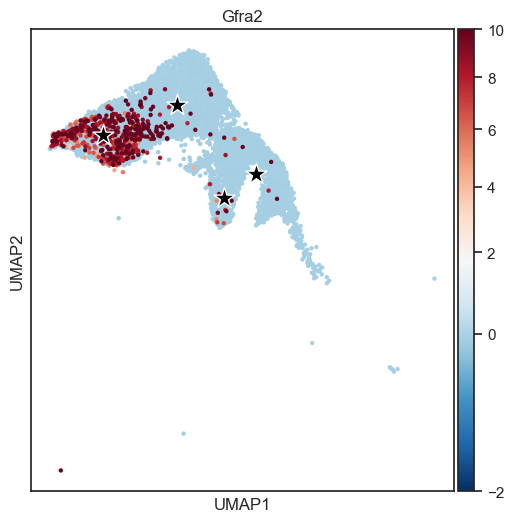

In [56]:
import matplotlib
ax = sc.pl.umap(inter,
           color=["Gfra2"],cmap = "RdBu_r",
                norm=matplotlib.colors.PowerNorm(gamma=0.6,vmin=-2),size = 40,ncols=2,
                show = False)

center1 = inter[inter.obs["vitae_new_clustering"] == "CThPN"].obsm["X_umap"].mean(axis=0)
center2 = inter[inter.obs["vitae_new_clustering"] == "Layer 6b"].obsm["X_umap"].mean(axis=0)
center3 = inter[inter.obs["vitae_new_clustering"] == "Interneurons"].obsm["X_umap"].mean(axis=0)
center4 = inter[inter.obs["vitae_new_clustering"] == "Immature neurons"].obsm["X_umap"].mean(axis=0)

ax.scatter(x=center1[0],y=center1[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center2[0],y=center2[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center3[0],y=center3[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center4[0],y=center4[1],marker='*',s = 250,c="black",edgecolors="white")

#ax.figure.savefig("figures/Interneurons_Gfra2.pdf",dpi = 700, bbox_inches='tight')

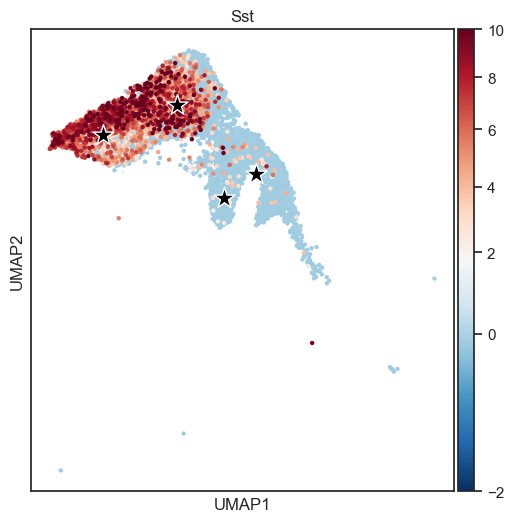

In [57]:
ax = sc.pl.umap(inter,
           color=["Sst"],cmap = "RdBu_r",
                norm=matplotlib.colors.PowerNorm(gamma=0.6,vmin=-2),size = 40,ncols=2,
                show = False)

center1 = inter[inter.obs["vitae_new_clustering"] == "CThPN"].obsm["X_umap"].mean(axis=0)
center2 = inter[inter.obs["vitae_new_clustering"] == "Layer 6b"].obsm["X_umap"].mean(axis=0)
center3 = inter[inter.obs["vitae_new_clustering"] == "Interneurons"].obsm["X_umap"].mean(axis=0)
center4 = inter[inter.obs["vitae_new_clustering"] == "Immature neurons"].obsm["X_umap"].mean(axis=0)

ax.scatter(x=center1[0],y=center1[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center2[0],y=center2[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center3[0],y=center3[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center4[0],y=center4[1],marker='*',s = 250,c="black",edgecolors="white")

#ax.figure.savefig("figures/Interneurons_Sst.pdf",dpi = 700, bbox_inches='tight')

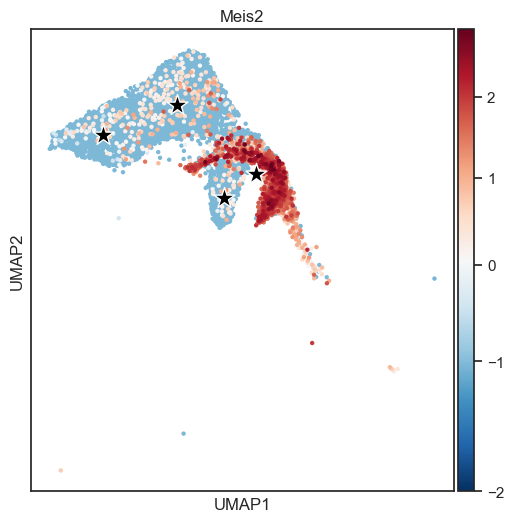

In [58]:
ax = sc.pl.umap(inter,
           color=["Meis2"],cmap = "RdBu_r",
                norm=matplotlib.colors.PowerNorm(gamma=0.8,vmin=-2),size = 40,ncols=2,
                show = False)

center1 = inter[inter.obs["vitae_new_clustering"] == "CThPN"].obsm["X_umap"].mean(axis=0)
center2 = inter[inter.obs["vitae_new_clustering"] == "Layer 6b"].obsm["X_umap"].mean(axis=0)
center3 = inter[inter.obs["vitae_new_clustering"] == "Interneurons"].obsm["X_umap"].mean(axis=0)
center4 = inter[inter.obs["vitae_new_clustering"] == "Immature neurons"].obsm["X_umap"].mean(axis=0)

ax.scatter(x=center1[0],y=center1[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center2[0],y=center2[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center3[0],y=center3[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center4[0],y=center4[1],marker='*',s = 250,c="black",edgecolors="white")

#ax.figure.savefig("figures/Interneurons_Meis2.pdf",dpi = 700, bbox_inches='tight')

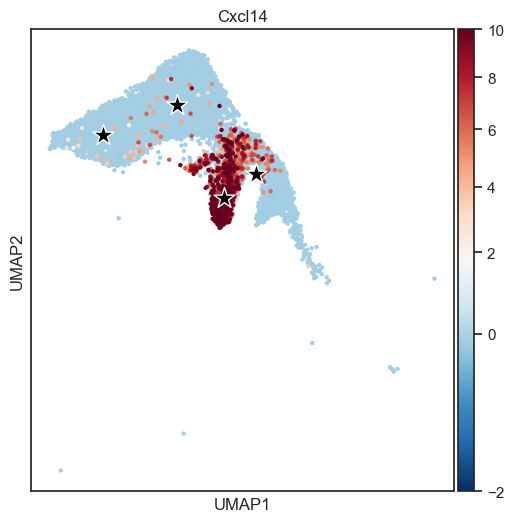

In [59]:
ax = sc.pl.umap(inter,
           color=["Cxcl14"],cmap = "RdBu_r",
                norm=matplotlib.colors.PowerNorm(gamma=0.6,vmin=-2),size = 40,ncols=2,
                show = False)

center1 = inter[inter.obs["vitae_new_clustering"] == "CThPN"].obsm["X_umap"].mean(axis=0)
center2 = inter[inter.obs["vitae_new_clustering"] == "Layer 6b"].obsm["X_umap"].mean(axis=0)
center3 = inter[inter.obs["vitae_new_clustering"] == "Interneurons"].obsm["X_umap"].mean(axis=0)
center4 = inter[inter.obs["vitae_new_clustering"] == "Immature neurons"].obsm["X_umap"].mean(axis=0)

ax.scatter(x=center1[0],y=center1[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center2[0],y=center2[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center3[0],y=center3[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center4[0],y=center4[1],marker='*',s = 250,c="black",edgecolors="white")

#ax.figure.savefig("figures/Interneurons_Cxcl14.pdf",dpi = 700, bbox_inches='tight')

### Fig 5.g

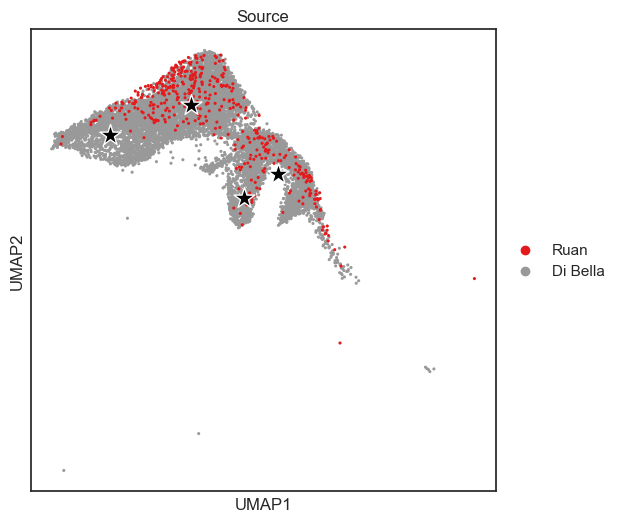

In [54]:
ax = sc.pl.umap(inter,
           color=["Source"],palette="Set1",size = 20,ncols=2,
                show = False)

center1 = inter[inter.obs["vitae_new_clustering"] == "CThPN"].obsm["X_umap"].mean(axis=0)
center2 = inter[inter.obs["vitae_new_clustering"] == "Layer 6b"].obsm["X_umap"].mean(axis=0)
center3 = inter[inter.obs["vitae_new_clustering"] == "Interneurons"].obsm["X_umap"].mean(axis=0)
center4 = inter[inter.obs["vitae_new_clustering"] == "Immature neurons"].obsm["X_umap"].mean(axis=0)

ax.scatter(x=center1[0],y=center1[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center2[0],y=center2[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center3[0],y=center3[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center4[0],y=center4[1],marker='*',s = 250,c="black",edgecolors="white")

#ax.figure.savefig("figures/Interneurons_Source.pdf",dpi = 700, bbox_inches='tight')

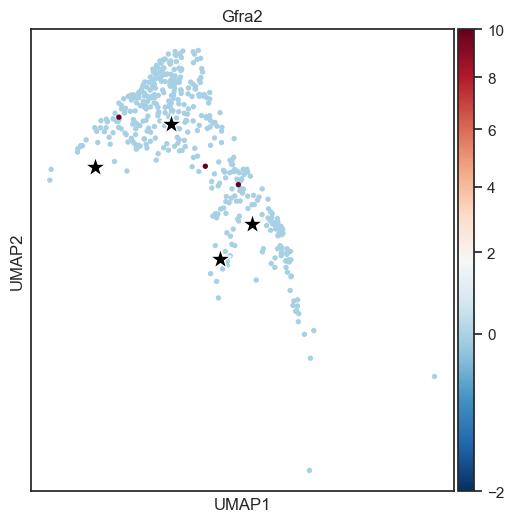

In [60]:
sub_inter = inter[inter.obs["Source"]!="Di Bella"]

ax = sc.pl.umap(sub_inter,
           color=["Gfra2"],cmap = "RdBu_r",
                norm=matplotlib.colors.PowerNorm(gamma=0.6,vmin=-2),size = 60,ncols=2,
                show = False)

center1 = inter[inter.obs["vitae_new_clustering"] == "CThPN"].obsm["X_umap"].mean(axis=0)
center2 = inter[inter.obs["vitae_new_clustering"] == "Layer 6b"].obsm["X_umap"].mean(axis=0)
center3 = inter[inter.obs["vitae_new_clustering"] == "Interneurons"].obsm["X_umap"].mean(axis=0)
center4 = inter[inter.obs["vitae_new_clustering"] == "Immature neurons"].obsm["X_umap"].mean(axis=0)

ax.scatter(x=center1[0],y=center1[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center2[0],y=center2[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center3[0],y=center3[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center4[0],y=center4[1],marker='*',s = 250,c="black",edgecolors="white")

#ax.figure.savefig("figures/SubInterneurons_Gfra2.pdf",dpi = 700, bbox_inches='tight')

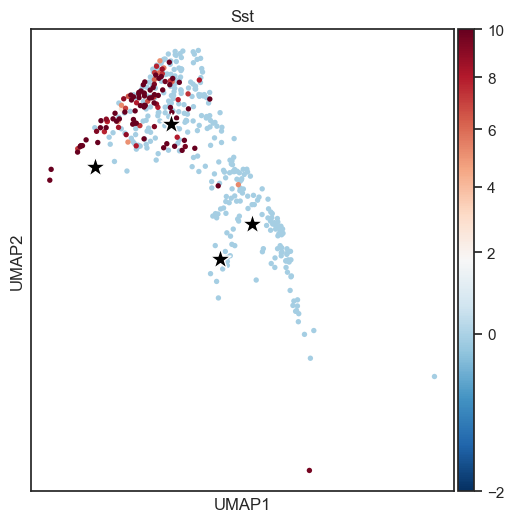

In [61]:
ax = sc.pl.umap(sub_inter,
           color=["Sst"],cmap = "RdBu_r",
                norm=matplotlib.colors.PowerNorm(gamma=0.6,vmin=-2),size = 60,ncols=2,
                show = False)

center1 = inter[inter.obs["vitae_new_clustering"] == "CThPN"].obsm["X_umap"].mean(axis=0)
center2 = inter[inter.obs["vitae_new_clustering"] == "Layer 6b"].obsm["X_umap"].mean(axis=0)
center3 = inter[inter.obs["vitae_new_clustering"] == "Interneurons"].obsm["X_umap"].mean(axis=0)
center4 = inter[inter.obs["vitae_new_clustering"] == "Immature neurons"].obsm["X_umap"].mean(axis=0)

ax.scatter(x=center1[0],y=center1[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center2[0],y=center2[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center3[0],y=center3[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center4[0],y=center4[1],marker='*',s = 250,c="black",edgecolors="white")

#ax.figure.savefig("figures/SubInterneurons_Sst.pdf",dpi = 700, bbox_inches='tight')

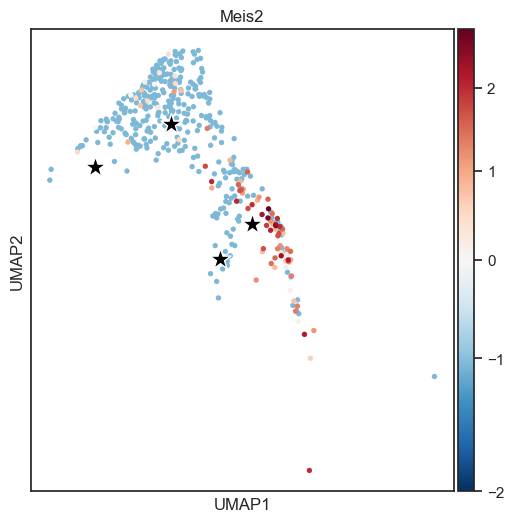

In [62]:
ax = sc.pl.umap(sub_inter,
           color=["Meis2"],cmap = "RdBu_r",
                norm=matplotlib.colors.PowerNorm(gamma=0.8,vmin=-2),size = 60,ncols=2,
                show = False)

center1 = inter[inter.obs["vitae_new_clustering"] == "CThPN"].obsm["X_umap"].mean(axis=0)
center2 = inter[inter.obs["vitae_new_clustering"] == "Layer 6b"].obsm["X_umap"].mean(axis=0)
center3 = inter[inter.obs["vitae_new_clustering"] == "Interneurons"].obsm["X_umap"].mean(axis=0)
center4 = inter[inter.obs["vitae_new_clustering"] == "Immature neurons"].obsm["X_umap"].mean(axis=0)

ax.scatter(x=center1[0],y=center1[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center2[0],y=center2[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center3[0],y=center3[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center4[0],y=center4[1],marker='*',s = 250,c="black",edgecolors="white")

#ax.figure.savefig("figures/SubInterneurons_Meis2.pdf",dpi = 700, bbox_inches='tight')

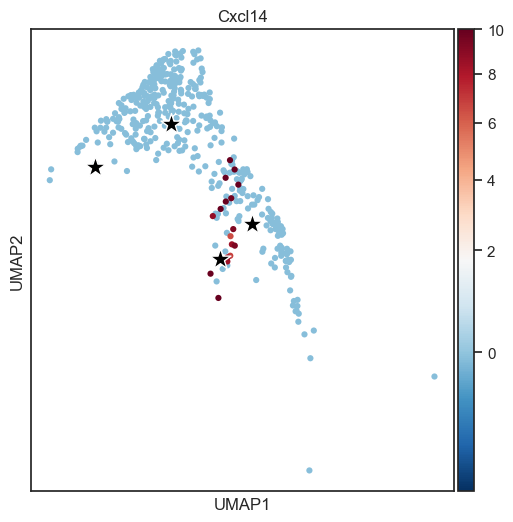

In [63]:
ax = sc.pl.umap(sub_inter,
           color=["Cxcl14"],cmap = "RdBu_r",
                norm=matplotlib.colors.PowerNorm(gamma=0.5,vmin=-1),size = 80,ncols=2,
                show = False)

center1 = inter[inter.obs["vitae_new_clustering"] == "CThPN"].obsm["X_umap"].mean(axis=0)
center2 = inter[inter.obs["vitae_new_clustering"] == "Layer 6b"].obsm["X_umap"].mean(axis=0)
center3 = inter[inter.obs["vitae_new_clustering"] == "Interneurons"].obsm["X_umap"].mean(axis=0)
center4 = inter[inter.obs["vitae_new_clustering"] == "Immature neurons"].obsm["X_umap"].mean(axis=0)

ax.scatter(x=center1[0],y=center1[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center2[0],y=center2[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center3[0],y=center3[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center4[0],y=center4[1],marker='*',s = 250,c="black",edgecolors="white")

#ax.figure.savefig("figures/SubInterneurons_Cxcl14.pdf",dpi = 700, bbox_inches='tight')

### Fig 5.d

In [103]:
vertex = ["Cycling glial cells","Ependymocytes","IPC"]
ap = model._adata[model._adata.obs["vitae_new_clustering"].isin(vertex)].copy()
w_proj = model.cell_position_projected[model._adata.obs["vitae_new_clustering"].isin(vertex),:]
idx1 = model.labels_map[model.labels_map.label_names == "Cycling glial cells"].index[0]
idx2 = model.labels_map[model.labels_map.label_names == "Ependymocytes"].index[0]
idx3 = model.labels_map[model.labels_map.label_names == "IPC"].index[0]

b1 = np.where((w_proj[:,idx1] > 0) & (w_proj[:,idx2] > 0))[0]
b2 = np.where((w_proj[:,idx1] > 0) & (w_proj[:,idx3] > 0))[0]

ap.obs["branch"] = 0
ap.obs["branch"][b1] = 1
ap.obs["branch"][b2] = 2

ap = ap[ap.obs["branch"]!=0]
#ap = ap[ap.obs["vitae_init_clustering"] == 'Apical progenitors'].copy()
ap.obs["branch"] =ap.obs["branch"].astype("category")

ap.obs["ap_cluster"] = ap.obs["tidy_clusters"].copy()
mask = ~ap.obs["tidy_clusters"].isin(["Apical progenitors","Cycling glial cells","IPC","Astrocytes"])
ap.obs["ap_cluster"][mask]=np.nan

ap = ap[ap.obs["vitae_init_clustering"] == 'Apical progenitors'].copy()

ap.obs["branch"] = ap.obs["branch"].astype(str)
ap.obs["branch"][ap.obs["branch"]=="1"] = "Apical progenitors -> Astrocytes"
ap.obs["branch"][ap.obs["branch"]=="2"] = "Apical progenitors -> IPC"

D:\Anaconda_new\envs\bio_traj10\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
D:\Anaconda_new\envs\bio_traj10\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
Trying to set attribute `.obs` of view, copying.
D:\Anaconda_new\envs\bio_traj10\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

D:\Anaconda_new\envs\bio_traj10\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'branch' as categorical


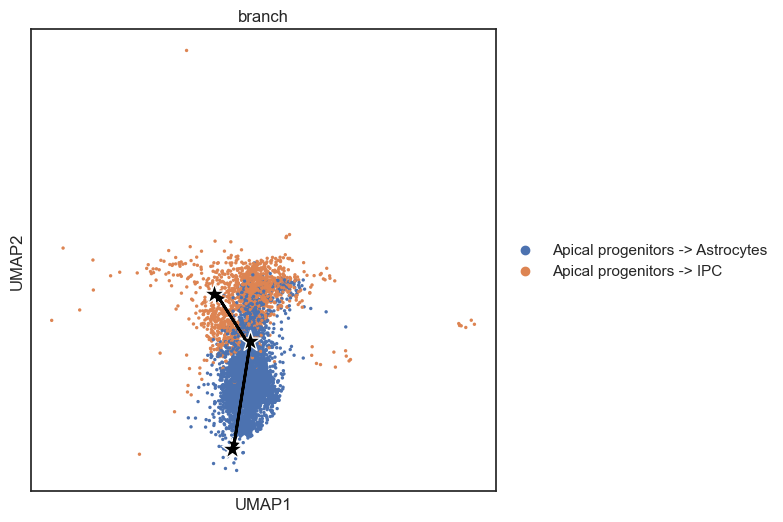

In [104]:
seaborn.set(rc={'figure.figsize':(6,6)},style = "white")
ax = sc.pl.umap(ap,color="branch",show=False)
ax.scatter(x=center1[0],y=center1[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center2[0],y=center2[1],marker='*',s = 250,c="black",edgecolors="white")
ax.scatter(x=center3[0],y=center3[1],marker='*',s = 250,c="black",edgecolors="white")
ax.arrow(x=center1[0],y=center1[1]-0.2,
         dx=center2[0]-center1[0]+0.06,
         dy=center2[1]-center1[1]+0.3,
        length_includes_head=True,
        head_width=0.2, head_length=0.15,
        #edgecolor = "white",
        #facecolor = "black",
         color = "black",
        linewidth = 2)

ax.arrow(x=center1[0]-0.2,y=center1[1]+0.1,
         dx=center3[0]-center1[0]+0.35,
         dy=center3[1]-center1[1]-0.15,
        length_includes_head=True,
        head_width=0.2, head_length=0.18,
        #edgecolor = "white",
        #facecolor = "black",
         color = "black",
        linewidth = 2)

In [105]:
from scipy.stats import ttest_ind
res = ttest_ind(ap[ap.obs["branch"]=="Apical progenitors -> IPC"].X,
                ap[ap.obs["branch"]=="Apical progenitors -> Astrocytes"].X,
                permutations=False)
ttest_gene = list(ap.var_names[np.argsort(res[1])[:10]])
ttest_gene

['Fabp7',
 'Mt3',
 'Neurog2',
 'Gadd45g',
 'Aldoc',
 'Dbi',
 'Pea15a',
 'Ddah1',
 'Ptprz1',
 'Hes6']

In [64]:
# reload the data so that the data is not scale

#has been normalize_total and log transform 
dd=sc.read("C:\\Users\\10270\\Desktop\\硕一上\\Wang\\Data\\transform.h5ad")

np.sum(np.exp(dd.X[0].todense())-1)

data_loc="C:\\Users\\10270\\Desktop\\硕一上\\Wang\\Data\\"
metadata = pd.read_csv(data_loc + 'metaData_scDevSC.txt', delimiter='\t', index_col = 0)

dd.obs['Day'] = metadata['orig_ident'][1:metadata.shape[0]]
dd.obs['Clusters'] = metadata['New_cellType'][1:metadata.shape[0]]
dd.obs['Clusters'] = pd.Categorical(dd.obs['Clusters'], categories = [
    'Apical progenitors', 'Intermediate progenitors', 'Migrating neurons',
    'Immature neurons', 'Cajal Retzius cells', 'CThPN', 'SCPN',
    'NP', 'Layer 6b', 'Layer 4', 'DL CPN', 'DL_CPN_1', 'DL_CPN_2', 'UL CPN',
    'Interneurons', 'Astrocytes', 'Oligodendrocytes', 'Microglia',
    'Cycling glial cells', 'Ependymocytes', 'Endothelial cells',
    'VLMC', 'Pericytes','Red blood cells', 'Doublet', 'Low quality cells'
    ], ordered = True)


dd.obs['S_Score'] = pd.to_numeric(metadata['S_Score'][1:metadata.shape[0]])
dd.obs['G2M_Score'] = pd.to_numeric(metadata['G2M_Score'][1:metadata.shape[0]])

dd = dd[dd.obs['Clusters'].isin(['Doublet', 'Low quality cells']) == False]

dd.obs.index=dd.obs.index.tolist()
dd.obs['Day']=dd.obs['Day'].tolist()
dd.obs['Clusters']=dd.obs['Clusters'].tolist()
dd.obs['S_Score']=dd.obs['S_Score'].tolist()
dd.obs['G2M_Score']=dd.obs['G2M_Score'].tolist()

sc.pp.highly_variable_genes(dd, flavor = "seurat")
#sc.pp.scale(dd, max_value=10)

day18 = np.array([np.nan] * dd.shape[0]).astype(object)
day18[(dd.obs["Day"] == "E18").values] = "E18"
day18[(dd.obs["Day"] == "E18_S1").values] = "E18_S1"
day18[(dd.obs["Day"] == "E18_S3").values] = "E18_S3"
dd.obs["merge_day_18"] = day18

dayP1 = np.array([np.nan] * dd.shape[0]).astype(object)
dayP1[dd.obs["Day"] == "P1"] = "P1"
dayP1[dd.obs["Day"] == "P1_S1"] = "P1_S1"
dd.obs["merge_P1"] = dayP1

dd.obs["merge_day_18"] = dd.obs["merge_day_18"].astype("category")
dd.obs["merge_P1"] = dd.obs["merge_P1"].astype("category")

dd.obs["Source"] = "Di Bella"

## Preprocess Mouse dataset

from VITAE.utils import load_data

mouse  = load_data(path = "D:/BioData/", file_name = "mouse_brain_merged")
sc.pp.normalize_total(mouse, target_sum=1e4)
sc.pp.log1p(mouse)
sc.pp.highly_variable_genes(mouse, min_mean=0.0125, max_mean=3, min_disp=0.5)
#sc.pp.scale(mouse, max_value=10)

mouse_source = np.repeat("Yuzwa",mouse.shape[0]).astype('<U16')
mouse_source[mouse.obs["covariate_2"]==0] = "Ruan"
mouse.obs["Source"] = mouse_source

mouse_day = mouse.obs.index.values.copy()
mouse_day = [x[:3] for x in mouse_day]
mouse.obs["Day"] = mouse_day

mouse.obs.rename(columns={"grouping": "Clusters", "covariate_0": "S_Score",
                     "covariate_1":"G2M_Score"},inplace = True)

## Merge two datasets

dd = dd.concatenate(mouse,join="inner")

group_dict = {"Immature Neuron" : "Immature neurons",
             "NEC":"Apical progenitors",
             "RGC":"Apical progenitors",
              "Layer I":"Cajal Retzius cells",
             "OPC":"Oligodendrocytes",
             "Interneurons":"Interneurons",
             "Endothelial Cell":"Endothelial cells",
             "Microglia":"Microglia",
             "Pericyte":"Pericytes",
             "Intermediate progenitors":"IPC"}

c = dd.obs["Clusters"].values.copy()
c = [x if group_dict.get(x) == None else group_dict.get(x) for x in c]
dd.obs["tidy_clusters"] = c.copy()

a = np.zeros(dd.shape[0])
a[dd.obs["Source"] == "Ruan"] = 1
dd.obs["cov1"] = a

a = np.zeros(dd.shape[0])
a[dd.obs["Source"] == "Yuzwa"] = 1
dd.obs["cov2"] = a

a = np.zeros(dd.shape[0])
a[dd.obs["Source"] == "Di Bella"] = 1
dd.obs["cov3"] = a

a = np.array([np.nan] * dd.shape[0])
#here is where I change
a[dd.obs["Day"] == "E18"] = 1
a[dd.obs["Day"] == "E18_S1"] = 2
a[dd.obs["Day"] == "E18_S3"] = 3
dd.obs["merge_18"] = a


a = np.array([np.nan] * dd.shape[0])
a[dd.obs["Day"] == "P1"] = 1
a[dd.obs["Day"] == "P1_S1"] = 2
dd.obs["merge_P1"] = a

dd.obs["merge_18"] = dd.obs["merge_18"].astype("category")
dd.obs["merge_P1"] = dd.obs["merge_P1"].astype("category")

a = dd.obs["tidy_clusters"].values.copy().astype(str)
a[(dd.obs["Day"].isin(["E14","E15","E16"])) & (a == "SCPN")] = "SCPN1"
dd.obs["Cluster2"] = a.copy()

D:\Anaconda_new\envs\bio_traj10\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (2,3,4,5,6,7,9,10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
Trying to set attribute `.obs` of view, copying.


In [106]:
ap_label = ap.obs["branch"]
ap_no_scale = dd[ap_label.index]
ap_no_scale.obs["branch"] = ap_label

Trying to set attribute `.obs` of view, copying.


In [107]:
df = sc.get.obs_df(ap_no_scale, ttest_gene + ["branch","Source"])
df = df.set_index(['branch','Source']).stack().reset_index()
df.columns = ['branch', 'Source','gene', 'value']

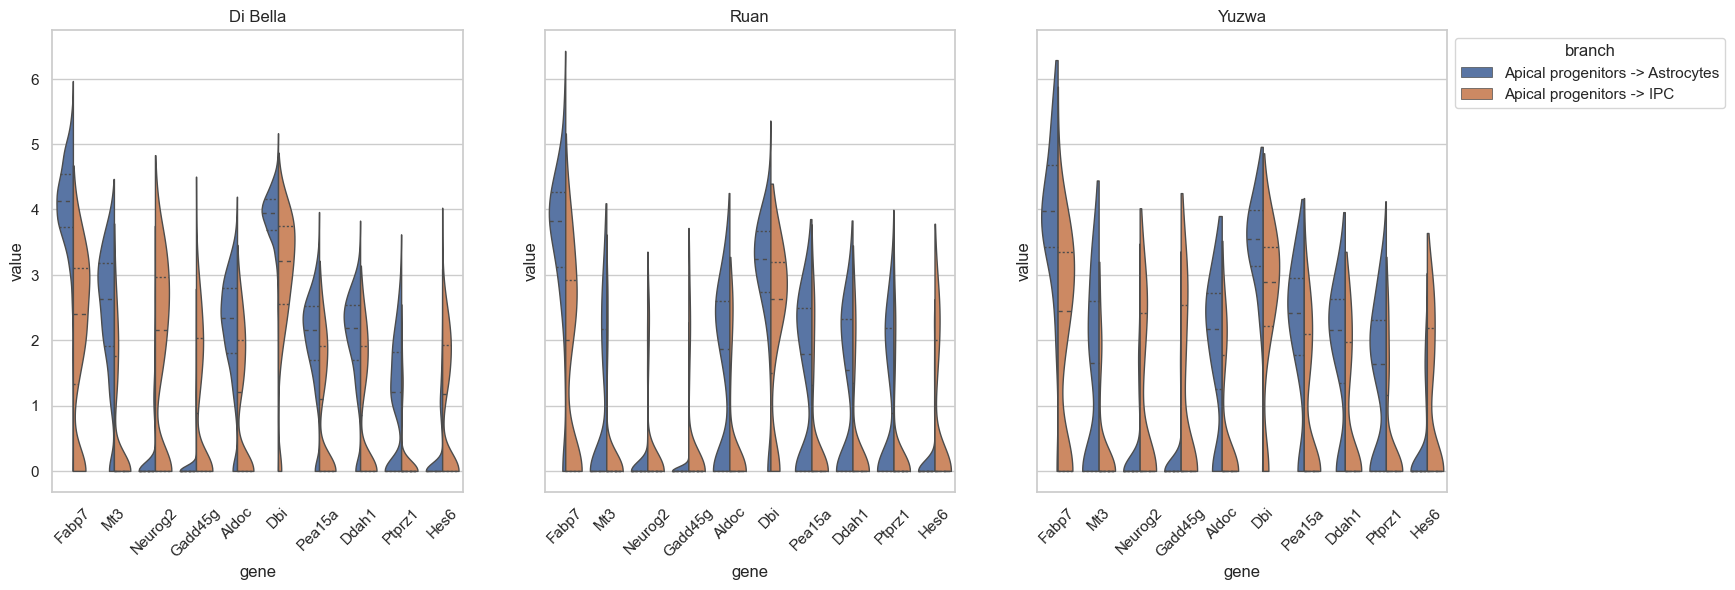

In [108]:
seaborn.set(style = "whitegrid")
fig, axes = plt.subplots(1,3,figsize=(18,6),sharey='row')

plt.setp(axes[0].get_xticklabels(), visible=True,rotation=45)
plt.setp(axes[1].get_xticklabels(), visible=True,rotation=45)
plt.setp(axes[2].get_xticklabels(), visible=True,rotation=45)
plt.setp(axes[0].get_yticklabels(), visible=True)

seaborn.set(rc={'figure.figsize':(6,18)},style = "white")
sns.violinplot(data=df[df.Source=="Di Bella"], x='gene', y='value', hue="branch",
                split=True, inner="quart", linewidth=1,scale="width",bw="silverman",cut = 0,ax=axes[0])

sns.violinplot(data=df[df.Source=="Ruan"], x='gene', y='value', hue="branch",
                split=True, inner="quart", linewidth=1,scale="width",bw="silverman",cut = 0,ax=axes[1])

sns.violinplot(data=df[df.Source=="Yuzwa"], x='gene', y='value', hue="branch",
                split=True, inner="quart", linewidth=1,scale="width",bw="silverman",cut = 0,ax=axes[2])
axes[0].get_legend().remove()
axes[0].set_title("Di Bella")
axes[1].get_legend().remove()
axes[1].set_title("Ruan")
#axes[2].get_legend().remove()
axes[2].set_title("Yuzwa")
sns.move_legend(axes[2], "upper left", bbox_to_anchor=(1, 1))
#plt.savefig("figures/ap_violin_ttest_gene.pdf",dpi = 400, bbox_inches='tight')

### Fig 4.b

In [123]:
np.savetxt("result/vitae_umap.txt",model._adata.obsm["X_umap"])
model._adata.obs.to_csv("result/vitae_meta.txt")

In [143]:
vitae_meta = pd.read_csv("result/vitae_meta.txt",index_col=0)
vitae_umap = np.loadtxt("result/vitae_umap.txt")

cca_meta = pd.read_csv("result/seurat_batch_correction_metadata.txt",delimiter=" ",index_col=0)
cca_umap = pd.read_csv("result/seurat_batch_correction_umap.txt",delimiter=" ",index_col=0).values

m_meta = pd.read_csv("result/monocle3_meta.txt",index_col=0,delimiter=" ")
m_umap = pd.read_csv("result/monocle3_umap.txt",index_col=0,delimiter=" ").values

D:\Anaconda_new\envs\bio_traj10\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (5,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [144]:
# X is umap here
vitae = sc.AnnData(X=vitae_umap,obs=vitae_meta)
vitae.obsm["X_umap"] = vitae_umap

cca = sc.AnnData(X=cca_umap,obs=cca_meta)
cca.obsm["X_umap"] = cca_umap

m = sc.AnnData(X=m_umap,obs=m_meta)
m.obsm["X_umap"] = m_umap

In [145]:
in_cell = np.intersect1d(vitae.obs.index,cca.obs.index)

# here is latent for vitae
vitae = vitae[in_cell].copy()
cca = cca[in_cell].copy()
m = m[in_cell].copy()

meta = vitae[in_cell].obs.copy()
vitae.obs = meta.copy()
cca.obs = meta.copy()
m.obs = meta.copy()

vitae_umap = vitae.obsm["X_umap"]
cca_umap = cca.obsm["X_umap"]
m_umap = m.obsm["X_umap"]

vitae_meta = vitae.obs.astype(str)
cca_meta = cca.obs.astype(str)
m_meta = m.obs.astype(str)

In [146]:
vitae.obs["merge_day_18"][vitae.obs["merge_day_18"] ==  "E18"] = np.nan
cca.obs["merge_day_18"][cca.obs["merge_day_18"] ==  "E18"] = np.nan
m.obs["merge_day_18"][m.obs["merge_day_18"] ==  "E18"] = np.nan

D:\Anaconda_new\envs\bio_traj10\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda_new\envs\bio_traj10\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda_new\envs\bio_traj10\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the i

In [147]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

def cal_E18(adata,k):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(adata.X, adata.obs["tidy_clusters"])
    closest_distances, indices = neigh.kneighbors(adata.X)
    adata.uns["K_neigh"] = indices

    neigh_source = adata.obs["merge_day_18"].values[adata.uns["K_neigh"]]

    my_source = np.array([adata.obs["merge_day_18"].values])
    my_source = my_source.T
    my_source = np.repeat(my_source,repeats=k,axis=1)

    same_with_me = np.sum(neigh_source == my_source,axis=1)
    same_in_pool = np.sum(np.isin(neigh_source,["E18_S1","E18_S3"]),axis=1)
    diff_with_me = same_in_pool - same_with_me
    
    loss1 = np.max(((same_with_me - k/2),np.zeros_like(same_with_me)),0)
    loss2 = np.max(((k/2 - diff_with_me),np.zeros_like(diff_with_me)),0)
    
    score = 1 - (loss1+loss2)/k
    return score

In [134]:
k=200
a = cal_E18(vitae,k)
b = cal_E18(cca,k)
c = cal_E18(m,k)

vitae.obs["score"] = a.copy()
cca.obs["score"] = b.copy()
m.obs["score"] = c.copy()

choose_type = vitae.obs[~pd.isna(vitae.obs["merge_18"])].groupby("tidy_clusters").count()["score"]>200

vitae_score =vitae.obs[~pd.isna(vitae.obs["merge_18"])]["score"]
cca_score = cca.obs[~pd.isna(vitae.obs["merge_18"])]["score"]
m_score = m.obs[~pd.isna(vitae.obs["merge_18"])]["score"]

score_df = pd.merge(vitae_score,cca_score,left_index=True,right_index=True)
score_df = pd.merge(score_df,m_score,left_index=True,right_index=True)
score_df.columns = ["VITAE","CCA","Monocle"]
score_df = (score_df - np.min(score_df.values))/(np.max(score_df.values) - np.min(score_df.values))
day18 = score_df.copy()

In [131]:
def cal_P1(adata,k):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(adata.X, adata.obs["tidy_clusters"])
    closest_distances, indices = neigh.kneighbors(adata.X)
    adata.uns["K_neigh"] = indices

    neigh_source = adata.obs["merge_P1"].values[adata.uns["K_neigh"]]

    my_source = np.array([adata.obs["merge_P1"].values])
    my_source = my_source.T
    my_source = np.repeat(my_source,repeats=k,axis=1)

    same_with_me = np.sum(neigh_source == my_source,axis=1)
    same_in_pool = np.sum(np.isin(neigh_source,[1,2]),axis=1)
    diff_with_me = same_in_pool - same_with_me
    
    loss1 = np.max(((same_with_me - k/2),np.zeros_like(same_with_me)),0)
    loss2 = np.max(((k/2 - diff_with_me),np.zeros_like(diff_with_me)),0)
    
    score = 1 - (loss1+loss2)/k
    return score

In [136]:
k=30
a = cal_P1(vitae,k)
b = cal_P1(cca,k)
c = cal_P1(m,k)

vitae.obs["score"] = a.copy()
cca.obs["score"] = b.copy()
m.obs["score"] = c.copy()

vitae_score =vitae.obs[~pd.isna(vitae.obs["merge_P1"])]["score"]
cca_score = cca.obs[~pd.isna(vitae.obs["merge_P1"])]["score"]
m_score = m.obs[~pd.isna(vitae.obs["merge_P1"])]["score"]


score_df = pd.merge(vitae_score,cca_score,left_index=True,right_index=True)
score_df = pd.merge(score_df,m_score,left_index=True,right_index=True)
score_df.columns = ["VITAE","CCA","Monocle"]
score_df = (score_df - np.min(score_df.values))/(np.max(score_df.values) - np.min(score_df.values))
dayp1 = score_df.copy()

In [132]:
#adata.X should be embedding
def cal_day(adata,k):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(adata.X, adata.obs["Day"])
    closest_distances, indices = neigh.kneighbors(adata.X)
    neigh_source = adata.obs["Day"].values[indices]
    my_source = np.array([adata.obs["Day"].values])
    my_source = my_source.T
    my_source = np.repeat(my_source,repeats=k,axis=1)
    
    same_with_me = np.sum(neigh_source == my_source,axis=1)
    diff_with_me = k - same_with_me
    
    n_days = len(np.unique(adata.obs["Day"]))
    loss1 = np.max(((same_with_me - k/n_days),np.zeros_like(same_with_me)),0)
    loss2 = np.max(((k - k/n_days - diff_with_me),np.zeros_like(diff_with_me)),0)
    
    score = 1 - (loss1+loss2)/(2*k-2/n_days*k)
    
    return score

In [138]:
k=200
a = cal_day(vitae,k)
b = cal_day(cca,k)
c = cal_day(m,k)

vitae.obs["score"] = a.copy()
cca.obs["score"] = b.copy()
m.obs["score"] = c.copy()

vitae_score = vitae.obs["score"]
cca_score = cca.obs["score"]
m_score = m.obs["score"]

score_df = pd.merge(vitae_score,cca_score,left_index=True,right_index=True)
score_df = pd.merge(score_df,m_score,left_index=True,right_index=True)
score_df.columns = ["VITAE","CCA","Monocle"]
score_df = (score_df - np.min(score_df.values))/(np.max(score_df.values) - np.min(score_df.values))
day = score_df.copy()

In [140]:
#adata.X should be embedding
def cal_type_day(adata,k):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(adata.X, adata.obs["type_days"])
    closest_distances, indices = neigh.kneighbors(adata.X)
    neigh_source = adata.obs["type_days"].values[indices]
    my_source = np.array([adata.obs["type_days"].values])
    my_source = my_source.T
    my_source = np.repeat(my_source,repeats=k,axis=1)
    
    same_with_me = np.sum(neigh_source == my_source,axis=1)
    diff_with_me = k - same_with_me
    
    n_clusters = len(np.unique(adata.obs["type_days"]))
    loss1 = np.max(((same_with_me - k/n_clusters),np.zeros_like(same_with_me)),0)
    loss2 = np.max(((k - k/n_clusters - diff_with_me),np.zeros_like(diff_with_me)),0)
    
    score = 1 - (loss1+loss2)/(2*k-2/n_clusters*k)
    
    return score

def tidy_days(adata):
    temp = adata.obs["Day"].copy()
    temp[temp=="E18_S1"] = "E18"
    temp[temp=="E18_S3"] = "E18"
    temp[temp=="P1_S1"] = "P1"
    adata.obs["tidy_days"] = temp.copy()
    return adata

In [150]:
tidy_days(vitae)
tidy_days(cca)
tidy_days(m)

vitae.obs["type_days"] = vitae.obs["tidy_clusters"] +"_"+ vitae.obs["tidy_days"]
cca.obs["type_days"] = cca.obs["tidy_clusters"] +"_"+ cca.obs["tidy_days"]
m.obs["type_days"] = m.obs["tidy_clusters"] +"_"+ m.obs["tidy_days"]

c1 = np.unique(vitae.obs["type_days"][vitae.obs["Source"]=="Di Bella"])
c2 = np.unique(vitae.obs["type_days"][vitae.obs["Source"]!="Di Bella"])
same_cell = np.intersect1d(c1,c2)

k = 100
vitae_score = cal_type_day(vitae[vitae.obs.type_days.isin(same_cell)],k=k)
cca_score = cal_type_day(cca[cca.obs.type_days.isin(same_cell)],k=k)
m_score = cal_type_day(m[m.obs.type_days.isin(same_cell)],k=k)

vitae_score = pd.DataFrame(index=vitae[vitae.obs.type_days.isin(same_cell)].obs.index, data = vitae_score )
cca_score = pd.DataFrame(index=cca[cca.obs.type_days.isin(same_cell)].obs.index, data = cca_score )
m_score = pd.DataFrame(index=m[m.obs.type_days.isin(same_cell)].obs.index, data = m_score )

score_df = pd.merge(vitae_score,cca_score,left_index=True,right_index=True)
score_df = pd.merge(score_df,m_score,left_index=True,right_index=True)
score_df.columns = ["VITAE","CCA","Monocle"]
score_df = (score_df - np.min(score_df.values))/(np.max(score_df.values) - np.min(score_df.values))
score_df = 1- score_df
cell = score_df.copy()

In [153]:
df1 = pd.DataFrame(day18.assign(Trial="Day18"))
df2 = pd.DataFrame(dayp1.assign(Trial="DayP1"))
df3 = pd.DataFrame(day.assign(Trial="Day"))
df4 = pd.DataFrame(cell.assign(Trial="cell"))

cdf = pd.concat([df1, df2, df3,df4])                                # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Trial'], var_name=['Method'])      # MELT

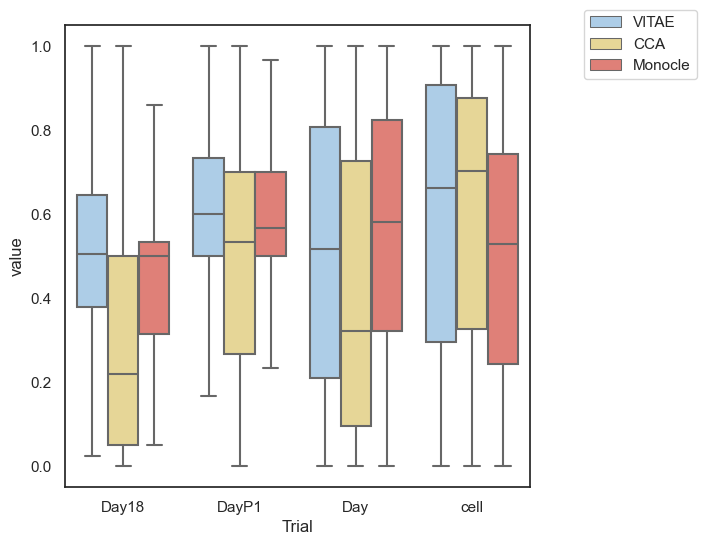

In [154]:
sns.set(rc={'figure.figsize':(6,6)})
sns.set_style("white")

ax = sns.boxplot(x="Trial", y="value", hue="Method", data=mdf,showfliers = False, boxprops=dict(alpha=1),palette=["#a3cef1","#f3de8a","#f07167"])  # RUN PLOT   
ax.legend(bbox_to_anchor=(1.1, 1.05))
#plt.savefig(path+"stack_legend.png",dpi = 400,bbox_inches='tight')

### Fig 4.a

In [161]:
from VITAE.utils import _get_smooth_curve
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

color_ggplot_15=["#F8766D","#EF7F48","#E48800","#D69100","#C69900","#B4A000","#9EA700",
                 "#83AD00","#60B200","#19B700","#00BB48","#00BE6B","#00C088","#00C1A2",
                 "#00C0BA","#00BECF","#00B9E1","#00B3F1","#00ABFD","#46A0FF","#8794FF",
                 "#B086FF","#CE79FF","#E46DF6","#F365E6","#FC61D4","#FF62BE","#FF67A6","#FE6E8B"]

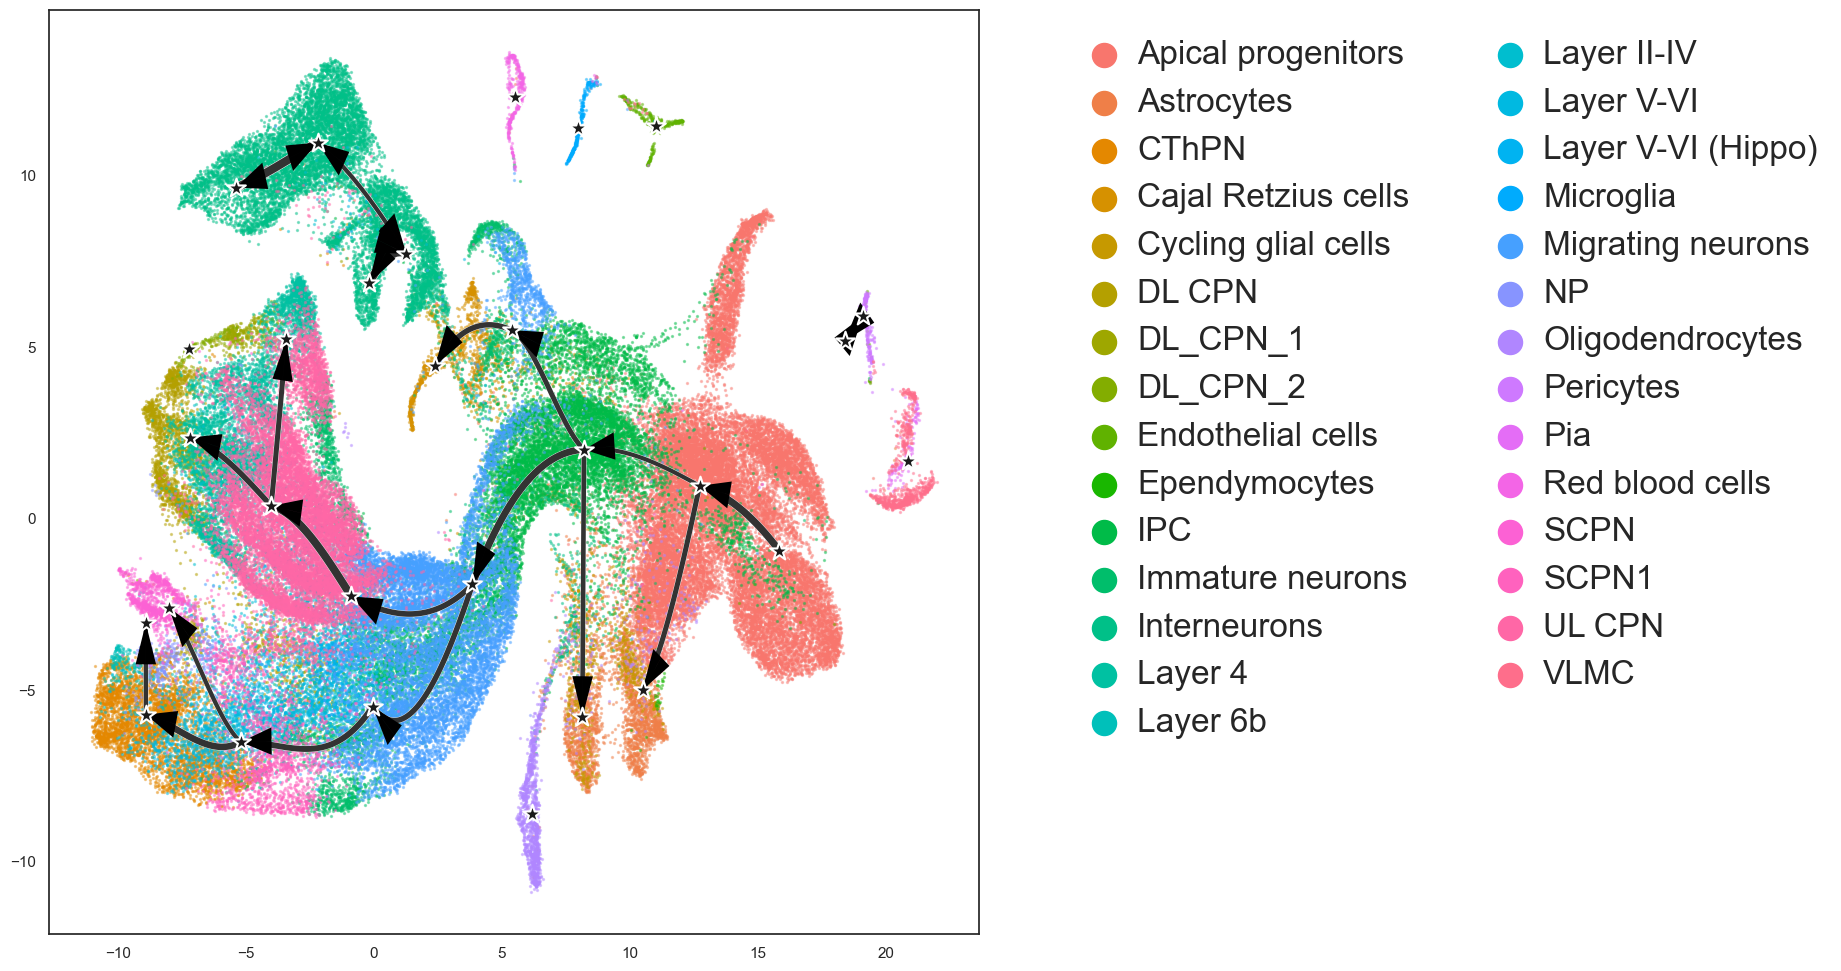

In [166]:
fig, axes = plt.subplots(1,1, figsize=(12, 12))

# our method
root = 'Apical progenitors'
method = 'UMAP'
# axes = model.visualize_latent(method = method, color='grouping', show=False, ax=axes)
dict_label_num = {j:i for i,j in model.labels_map['label_names'].to_dict().items()}
uni_cluster_labels = model.adata.obs['vitae_new_clustering'].cat.categories.copy()
# cluster_labels is used to calculated center
cluster_labels = model.adata.obs['vitae_new_clustering'].to_numpy()

#labels is used to color points
labels = model.adata.obs['vitae_init_clustering'].to_numpy()
embed_z = model._adata.obsm[model.dict_method_scname[method]]
embed_mu = np.zeros((len(uni_cluster_labels), 2))
for l in uni_cluster_labels:
    embed_mu[dict_label_num[l],:] = np.mean(embed_z[cluster_labels==l], axis=0)

for i,x in enumerate(uni_cluster_labels):
    axes.scatter(*embed_z[labels==x].T, c=[color_ggplot_15[i]],
        s=2, alpha=0.4, label=x)
    
graph = model.directed_backbone
select_edges = list(graph.edges)
select_edges_score = np.array([d['weight'] for (u,v,d) in graph.edges(data=True)])
if max(select_edges_score) - min(select_edges_score) == 0:
    select_edges_score = select_edges_score/max(select_edges_score)
else:
    select_edges_score = (select_edges_score - min(select_edges_score))/(max(select_edges_score) - min(select_edges_score))*3

#   colors = [plt.cm.jet(float(i)/self.n_states) for i in range(self.n_states)]
value_range = np.maximum(np.diff(axes.get_xlim())[0], np.diff(axes.get_ylim())[0])
y_range = np.min(embed_z[:,1]), np.max(embed_z[:,1], axis=0)
 
for i in range(len(select_edges)):
    points = embed_z[np.sum(model.cell_position_projected[:,select_edges[i]]>0, axis=-1)==2,:]
    points = points[points[:,0].argsort()]  
#     if select_edges[i,0]==0 and select_edges[i,1]==5:
#         # for better visualization purpose
#         points = points[points[:,1]> np.min(embed_mu[select_edges[i], 1])-0.02,:]
#         points = np.r_[points, 
#                        embed_mu[select_edges[i,0], :] + np.arange(50).reshape((50,1))/50 * np.array([[0.05,-0.1]])
#                        ]              
    x_smooth, y_smooth = _get_smooth_curve(
        points, 
        embed_mu[select_edges[i], :],
        y_range
        )
    axes.plot(x_smooth, y_smooth, 
        '-', 
        linewidth= 3 + select_edges_score[i],
        color="black", 
        alpha=0.8, 
        path_effects=[pe.Stroke(linewidth=2+select_edges_score[i]+1.5, 
                                foreground='white'), pe.Normal()],
        zorder=1
        )

    delta_x = embed_mu[select_edges[i][1], 0]-x_smooth[-2]
    delta_y = embed_mu[select_edges[i][1], 1]-y_smooth[-2]
    length = np.sqrt(delta_x**2 + delta_y**2) * 50           
    axes.arrow(
            embed_mu[select_edges[i][1], 0]-delta_x/length, 
            embed_mu[select_edges[i][1], 1]-delta_y/length, 
            delta_x/length,
            delta_y/length,
            color='black', alpha=1.0,
            shape='full', lw=0, length_includes_head=True, head_width=0.8, zorder=2)


axes.scatter(*embed_mu.T, s=200, color='k', marker='*',
                                linewidth=1.5, edgecolor='white', zorder=3)

box = axes.get_position()
axes.set_position([box.x0 + box.width*0.1, box.y0,
                    box.width * 0.9, box.height])
leg = axes.legend(loc='upper center', bbox_to_anchor=(1.5, 1.0),
            fancybox=False, shadow=False, markerscale=5, ncol=2, 
            frameon=False, handletextpad=0.01,
            prop={'size': 24})
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    #change the size of the marker in legend
    lh.set_sizes([300])
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=None)
#plt.savefig("C:/Users/10270/Desktop/硕一上/Wang/Trajectory/Dev/GitVersion/plot/traj/traj_whole_non_idx.png",dpi = 400, bbox_inches='tight');

### Fig S.4

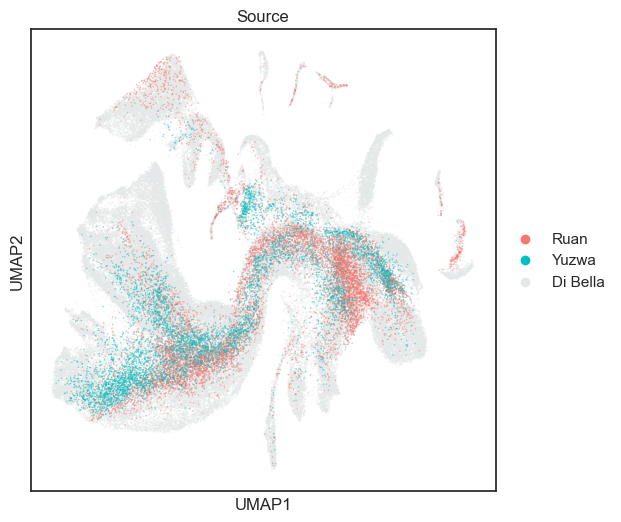

In [172]:
sc.pl.umap(model._adata,color="Source",size = 5,palette= ["#F8766D","#00BFC4","#E5E8E8"],alpha = 0.5,na_color="#E5E8E8")

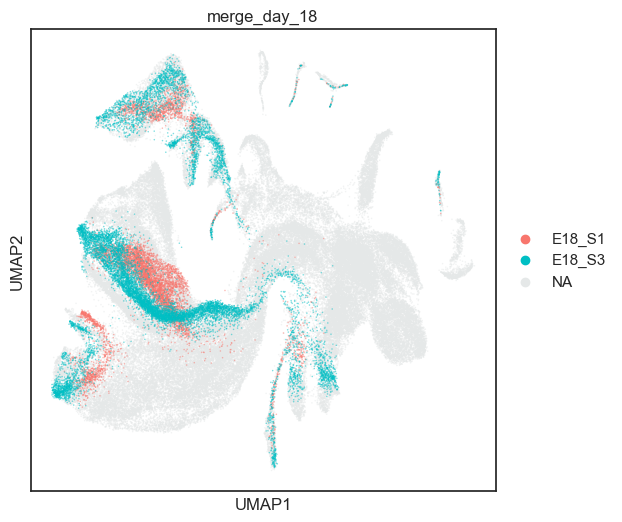

In [171]:
sc.pl.umap(model._adata,color="merge_day_18",size = 5,palette= ["#F8766D","#00BFC4","#E5E8E8"],alpha = 0.5,na_color="#E5E8E8")

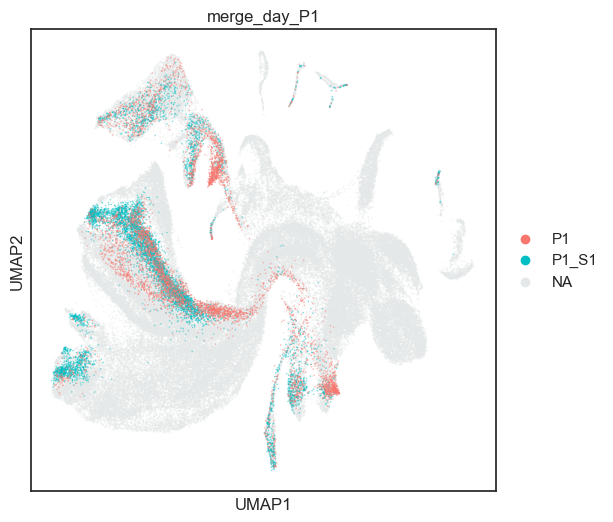

In [173]:
sc.pl.umap(model._adata,color="merge_day_P1",size = 5,palette= ["#F8766D","#00BFC4","#E5E8E8"],alpha = 0.5,na_color="#E5E8E8")

### Fig S.5

In [167]:
color_ggplot_15=["#F8766D","#EF7F48","#E48800","#D69100","#C69900","#B4A000","#9EA700",
                 "#83AD00","#60B200","#19B700","#00BB48","#00BE6B","#00C088","#00C1A2",
                 "#00C0BA","#00BECF","#00B9E1","#00B3F1","#00ABFD","#46A0FF","#8794FF",
                 "#B086FF","#CE79FF","#E46DF6","#F365E6","#FC61D4","#FF62BE","#FF67A6","#FE6E8B"]

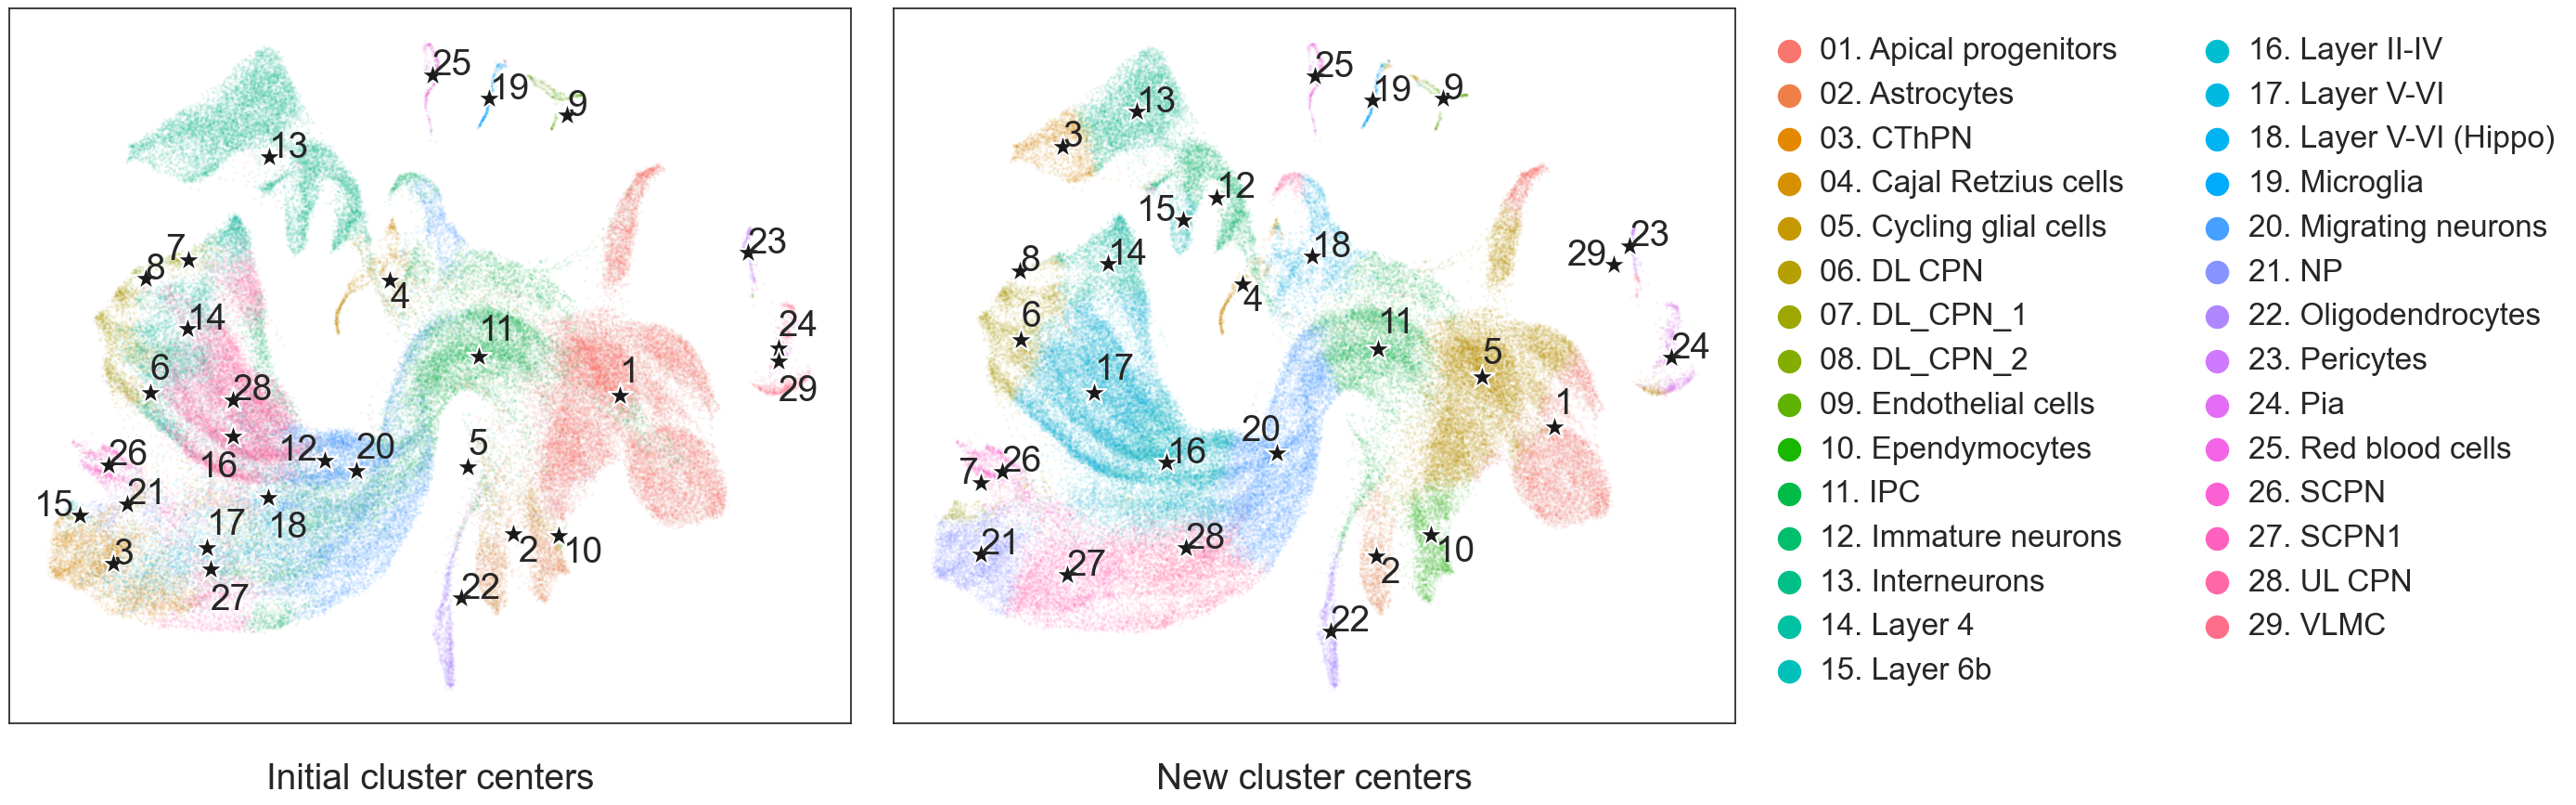

In [169]:
fig, axes = plt.subplots(1,2, figsize=(24, 10))
# our method
root = 'Apical progenitors'
method = 'UMAP'
# axes[1] = model.visualize_latent(method = method, color='grouping', show=False, ax=axes[1])
dict_label_num = {j:i for i,j in model.labels_map['label_names'].to_dict().items()}

##init clustering

uni_cluster_labels = model.adata.obs['vitae_new_clustering'].cat.categories.copy()
# cluster_labels is used to calculated center
cluster_labels = model.adata.obs['vitae_init_clustering'].to_numpy()

#labels is used to color points
labels = model.adata.obs['vitae_init_clustering'].to_numpy()
embed_z = model._adata.obsm[model.dict_method_scname[method]]
embed_mu = np.zeros((len(uni_cluster_labels), 2))
for l in uni_cluster_labels:
    embed_mu[dict_label_num[l],:] = np.mean(embed_z[cluster_labels==l], axis=0)

axes[0].scatter(*embed_mu.T, s=400, color='k', marker='*',
                                linewidth=1.5, edgecolor='white', zorder=3)

for i,x in enumerate(uni_cluster_labels):
    axes[0].scatter(*embed_z[labels==x].T, c=[color_ggplot_15[i]],
        s=2, alpha=0.05, label='%02d'%(i+1)+'. '+str(x))
    
    dx = dy =0
    if i == 0:
        dy = 0.5
    elif i == 4:
        dy = 0.5
    elif i == 9:
        dy = -1
        dx = 0.2
    elif i == 1:
        dy = -1
        dx = 0.2
    elif i == 10:
        dy = +0.6
    elif i == 19:
        dy = +0.5
        dx = 0
    elif i == 16:
        dy = +0.5
    elif i == 5:
        dy = +0.5
    elif i == 6:
        dx = -1
    elif i == 14:
        dx = -2
    elif i == 3:
        dy = -1
    elif i == 11:
        dx = -2
    elif i == 26:
        dy = -1.5
    elif i == 17:
        dy = -1.5
    elif i == 15:
        dy = -1.5
        dx = -1.5
    elif i == 28:
        dy = -1.5
    elif i == 23:
        dy = 0.5
    axes[0].text(np.mean(embed_z[cluster_labels==x,0])+dx, 
            np.mean(embed_z[cluster_labels==x,1])+dy, str(i+1), fontsize=28)



## new clustering

uni_cluster_labels = model.adata.obs['vitae_new_clustering'].cat.categories.copy()
# cluster_labels is used to calculated center
cluster_labels = model.adata.obs['vitae_new_clustering'].to_numpy()

#labels is used to color points
labels = model.adata.obs['vitae_new_clustering'].to_numpy()
embed_z = model._adata.obsm[model.dict_method_scname[method]]
embed_mu = np.zeros((len(uni_cluster_labels), 2))
for l in uni_cluster_labels:
    embed_mu[dict_label_num[l],:] = np.mean(embed_z[cluster_labels==l], axis=0)

axes[1].scatter(*embed_mu.T, s=400, color='k', marker='*',
                                linewidth=1.5, edgecolor='white', zorder=3)

for i,x in enumerate(uni_cluster_labels):
    axes[1].scatter(*embed_z[labels==x].T, c=[color_ggplot_15[i]],
        s=2, alpha=0.05, label='%02d'%(i+1)+'. '+str(x))
    
    dx = dy =0
    if i == 0:
        dy = 0.5
    elif i == 4:
        dy = 0.5
    elif i == 9:
        dy = -1
        dx = 0.2
    elif i == 1:
        dy = -1
        dx = 0.2
    elif i == 10:
        dy = +0.6
    elif i == 19:
        dy = +0.5
        dx = -1.5
    elif i == 16:
        dy = +0.5
    elif i == 5:
        dy = +0.5
    elif i == 6:
        dx = -1
    elif i == 28:
        dx = -2
    elif i == 14:
        dx = -2
    elif i == 3:
        dy = -1

    axes[1].text(np.mean(embed_z[cluster_labels==x,0])+dx, 
            np.mean(embed_z[cluster_labels==x,1])+dy, str(i+1), fontsize=28)

box = axes[1].get_position()
axes[1].set_position([box.x0 + box.width*0.1, box.y0,
                    box.width * 0.9, box.height])
leg = axes[1].legend(loc='upper center', bbox_to_anchor=(1.5, 1.0),
            fancybox=False, shadow=False, markerscale=5, ncol=2, 
            frameon=False, handletextpad=0.01,
            prop={'size': 24})
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    #change the size of the marker in legend
    lh.set_sizes([300])
    

axes[0].set_xlabel('Initial cluster centers', fontsize=28, labelpad=30)
axes[1].set_xlabel('New cluster centers', fontsize=28, labelpad=30)
plt.setp(axes[0], xticks=[], yticks=[])
plt.setp(axes[1], xticks=[], yticks=[])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=None)
#plt.savefig("center_shift.png",dpi = 700, bbox_inches='tight')

### Fig 5

In [178]:
vertex = ['Cycling glial cells',"IPC",'Migrating neurons']
a = model._adata.obs["vitae_new_clustering"].values.copy()
a[~a.isin(vertex)] = np.nan
model._adata.obs["sub_traj1"] = a.copy()
model.adata.obs["sub_traj1"] = a.copy()

w_proj = model.cell_position_projected.copy()
w_proj = pd.DataFrame(data=w_proj,columns=model.labels_map["label_names"].values)

idx = []
for i in range(len(vertex)):
    for j in range(i+1,len(vertex)):
        _idx = w_proj.index[(w_proj[vertex[i]] > 0) & (w_proj[vertex[j]] > 0)]
        idx += list(_idx)
        _idx = w_proj.index[w_proj[vertex[i]] == 1]
        idx += list(_idx)

D:\Anaconda_new\envs\bio_traj10\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda_new\envs\bio_traj10\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu").copy()
  import sys
No handles with labels found to put in legend.


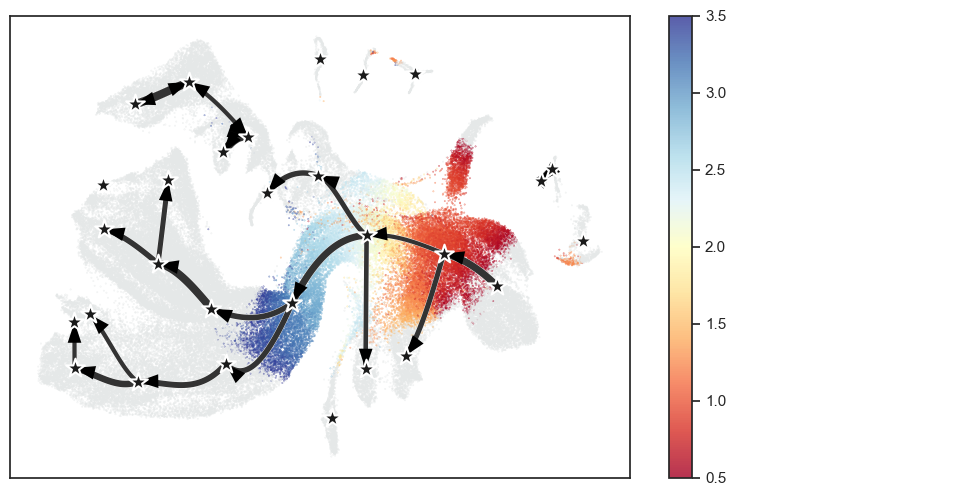

In [184]:
import matplotlib
model.adata.obs["sub_psd"] = model.adata.obs["pseudotime"].copy()
model.adata.obs["sub_psd"][pd.isna(model.adata.obs["sub_traj1"])] = 100

fig, axes = plt.subplots(1,1, figsize=(10, 6))
cm = plt.cm.get_cmap('RdYlBu')
cm.set_over("#E5E8E8")
sc = axes.scatter(*embed_z.T, c = model.adata.obs["sub_psd"],
        s=0.08, alpha=0.8,cmap=cm,vmin=0.5, vmax=3.5)
plt.colorbar(sc)

embed_mu = np.zeros((len(uni_cluster_labels), 2))
for l in uni_cluster_labels:
    embed_mu[dict_label_num[l],:] = np.mean(embed_z[cluster_labels==l], axis=0)
    
    
dict_label_num = {j:i for i,j in model.labels_map['label_names'].to_dict().items()}
uni_cluster_labels = model.adata.obs['vitae_new_clustering'].cat.categories.copy()
# cluster_labels is used to calculated center
cluster_labels = model.adata.obs['vitae_new_clustering'].to_numpy()

graph = model.directed_backbone
select_edges = list(graph.edges)
select_edges_score = np.array([d['weight'] for (u,v,d) in graph.edges(data=True)])
if max(select_edges_score) - min(select_edges_score) == 0:
    select_edges_score = select_edges_score/max(select_edges_score)
else:
    select_edges_score = (select_edges_score - min(select_edges_score))/(max(select_edges_score) - min(select_edges_score))*3

#   colors = [plt.cm.jet(float(i)/self.n_states) for i in range(self.n_states)]
value_range = np.maximum(np.diff(axes.get_xlim())[0], np.diff(axes.get_ylim())[0])
y_range = np.min(embed_z[:,1]), np.max(embed_z[:,1], axis=0)
 
for i in range(len(select_edges)):
    points = embed_z[np.sum(model.cell_position_projected[:,select_edges[i]]>0, axis=-1)==2,:]
    points = points[points[:,0].argsort()]  
#     if select_edges[i,0]==0 and select_edges[i,1]==5:
#         # for better visualization purpose
#         points = points[points[:,1]> np.min(embed_mu[select_edges[i], 1])-0.02,:]
#         points = np.r_[points, 
#                        embed_mu[select_edges[i,0], :] + np.arange(50).reshape((50,1))/50 * np.array([[0.05,-0.1]])
#                        ]              
    x_smooth, y_smooth = _get_smooth_curve(
        points, 
        embed_mu[select_edges[i], :],
        y_range
        )
    axes.plot(x_smooth, y_smooth, 
        '-', 
        linewidth= 3 + select_edges_score[i],
        color="black", 
        alpha=0.8, 
        path_effects=[pe.Stroke(linewidth=2+select_edges_score[i]+1.5, 
                                foreground='white'), pe.Normal()],
        zorder=1
        )

    delta_x = embed_mu[select_edges[i][1], 0]-x_smooth[-2]
    delta_y = embed_mu[select_edges[i][1], 1]-y_smooth[-2]
    length = np.sqrt(delta_x**2 + delta_y**2) * 50           
    axes.arrow(
            embed_mu[select_edges[i][1], 0]-delta_x/length, 
            embed_mu[select_edges[i][1], 1]-delta_y/length, 
            delta_x/length,
            delta_y/length,
            color='black', alpha=1.0,
            shape='full', lw=0, length_includes_head=True, head_width=0.8, zorder=2)


axes.scatter(*embed_mu.T, s=200, color='k', marker='*',
                                linewidth=1.5, edgecolor='white', zorder=3)

box = axes.get_position()
axes.set_position([box.x0 + box.width*0.1, box.y0,
                    box.width * 0.9, box.height])
leg = axes.legend(loc='upper center', bbox_to_anchor=(1.5, 1.0),
            fancybox=False, shadow=False, markerscale=5, ncol=2, 
            frameon=False, handletextpad=0.01,
            prop={'size': 24})

plt.setp(axes, xticks=[], yticks=[])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=None)
plt.show()

In [185]:
res_df = model.differential_expression_test(alpha = 0.05, cell_subset = idx,order=2)
res_df_strict = res_df[(res_df.pvalue_adjusted_1 < 0.05) | (res_df.pvalue_adjusted_2 < 0.05)].copy()

In [187]:
sub1 = model._adata[idx,res_df_strict.index].copy()
sub1.var["max_psd"] = sub1.obs["pseudotime"][np.argmax(sub1.X,axis=0)].values

In [188]:
# sort gene by peak psd time
sub1 = sub1[:,sub1.var["max_psd"].sort_values().index].copy()

In [189]:
# sort cell by psd time
sub1 = sub1[sub1.obs["pseudotime"].sort_values().index,:].copy()

In [190]:
list_x = sub1.obs["pseudotime"].values.astype(float)

for i in range(res_df_strict.shape[0]):
    list_y = sub1.X[:,i]
    poly = np.polyfit(list_x,list_y,6)
    poly_y = np.poly1d(poly)(list_x)
    sub1.X[:,i] = poly_y.copy()

In [191]:
sub1.var["max_psd"] = sub1.obs["pseudotime"][np.argmax(sub1.X,axis=0)].values

# sort gene by peak psd time
sub1 = sub1[:,sub1.var["max_psd"].sort_values().index].copy()

In [192]:
X = sub1.X.T.copy()
# normalized for each gene
X = (X - np.min(X,axis = 1).reshape(-1,1))/(np.max(X,axis = 1).reshape(-1,1)-np.min(X,axis = 1).reshape(-1,1))

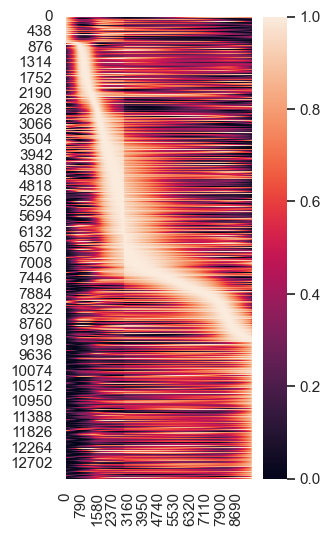

In [194]:
from matplotlib import colors
seaborn.set(rc={'figure.figsize':(3,6)},style = "white")
plot = sns.heatmap(X[:,(sub1.obs["Source"]=="Di Bella").values],norm=colors.PowerNorm(gamma=1))
#plot.get_figure().savefig(path+"sub2_0.png",dpi = 400) 

<AxesSubplot:>

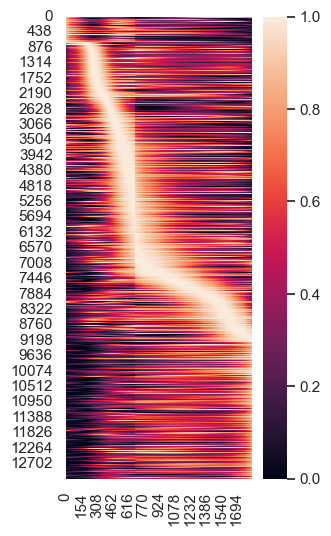

In [196]:
plot = sns.heatmap(X[:,(sub1.obs["Source"]=="Ruan").values],norm=colors.PowerNorm(gamma=1))
plot

<AxesSubplot:>

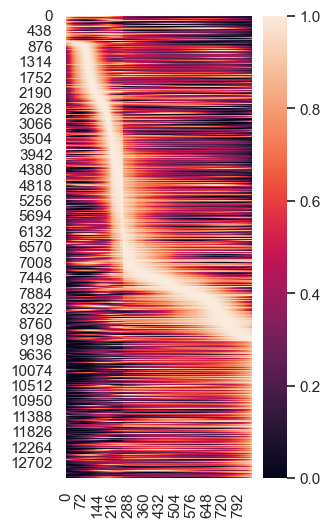

In [197]:
plot = sns.heatmap(X[:,(sub1.obs["Source"]=="Yuzwa").values],norm=colors.PowerNorm(gamma=1))
plot